In [1]:
!pip install wordcloud
!pip install Unidecode
!pip install python-louvain
!pip install --upgrade six
!pip install --upgrade pip 

!pip install --upgrade Pillow
!pip install fuzzywuzzy

## Part 0: Imports

In [2]:
import requests
import os, re
from datetime import datetime
from bs4 import BeautifulSoup
import json
import random
import string
from collections import Counter

from itertools import combinations
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

from fuzzywuzzy import fuzz

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
from tqdm import tqdm
from unidecode import unidecode
from country_named_entity_recognition import find_countries
import country_converter as coco

from typing import List, Dict
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import powerlaw
from community import community_louvain

import nltk
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.corpus.reader import PlaintextCorpusReader
from nltk.text import Text
from nltk.tokenize import word_tokenize, sent_tokenize
import string

import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib import cm

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('wordnet')

c:\Users\floco\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
c:\Users\floco\anaconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\floco\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\floco\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\floco\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_

True

## 1. Scraping the data

Our first mission was to scrap the data from nature.com and then preprocess it to get beautiful list of nodes (universities) and edges (collaborations between universities).

### 1.A. Scrapper

To do it, we decided to create a Scraper object with some functions to then be able to manipulate the data easily.

In [3]:
# Scraper class for extracting universities and collaborations from nature.com articles
class Scraper:
    def __init__(self):
        # Initializing class variables
        self.base_url = "https://www.nature.com" # The nature.com url
        self.year = 2023 # The year of the articles to be extracted
        self.unprocessed_universities = {} # Dictionnary to store the non processed universities
        self.universities = {}         # Dictionary to store universities and their occurrences
        self.collabs = {}              # Dictionary to store collaborations between universities
        self.raw_to_abstract_mapping = {}        # Mapping old university names to abstract names
        self.links_not_used_for_network = []         # List to save article links used for text preprocessing
        self.links_used_for_network = []         # List to save article links used in the network
        self.links_authors_countries_used_for_network = {}       # List to save countries of authors of the links saved for the netowrk

    # ---- METHODS TO LOAD JSON FROM FILES ----

    # Method to load a certain year
    def load_year_data(year):
        self.year = year
        self.load_universities(f"{year}/universities.json")
        self.load_collabs(f"{year}/collabs.json")
        self.load_links_used_for_network(f"{year}/links_used_for_network.json")
        self.load_links_not_used_for_network(f"{year}/links_not_used_for_network.json")
        self.load_links_authors_countries_used_for_network(f"{year}/links_authors_countries_used_for_network.json")

    # Method to load collaboration data from a JSON file
    def load_collabs(self, filename):
        with open(filename, 'r') as file:
            self.collabs = json.load(file)

    # Method to load unprocessed universities data from a JSON file
    def load_unpreprocessed_universities(self, filename):
        with open(filename, 'r') as file:
            self.unprocessed_universities = json.load(file)

    # Method to load universities data from a JSON file
    def load_universities(self, filename):
        with open(filename, 'r') as file:
            self.universities = json.load(file)

    # Method to load saved links not used for network from a JSON file
    def load_links_not_used_for_network(self, filename):
        with open(filename, 'r') as file:
            self.links_not_used_for_network = json.load(file)

    # Method to load links used for the network from a JSON file
    def load_links_used_for_network(self, filename):
        with open(filename, 'r') as file:
            self.links_used_for_network = json.load(file)

    # Method to load countries of the others of the articles we used for the network
    def load_links_authors_countries_used_for_network(self, filename):
        with open(filename, 'r') as file:
            self.links_authors_countries_used_for_network = json.load(file)

    # ---- METHODS TO SAVE JSON IN FILES ----

    # Method to save unprocessed universities data to a JSON file
    def save_unproccessed_universities_in_file(self):
        with open(f'{self.year}/unprocessed_universities.json', 'w') as fp:
            json.dump(self.unprocessed_universities, fp)

    # Method to save universities data to a JSON file
    def save_universities_in_file(self):
        with open(f'{self.year}/universities.json', 'w') as fp:
            json.dump(self.universities, fp)

    # Method to save collaborations data to a JSON file
    def save_collabs_in_file(self):
        with open(f'{self.year}/collabs.json', 'w') as fp:
            json.dump(self.collabs, fp)

    # Method to save links not used for network to a JSON file
    def save_links_not_used_for_network_in_file(self):
        with open(f'{self.year}/links_not_used_for_network.json', 'w') as fp:
            json.dump(self.links_not_used_for_network, fp)

    # Method to save saved links used for network to a JSON file
    def save_links_used_for_network_in_file(self):
        with open(f'{self.year}/links_used_for_network_in_file.json', 'w') as fp:
            json.dump(self.links_used_for_network, fp)

    # Method to save links authors countries used for network
    def save_links_authors_countries_used_for_network_in_file(self):
        with open(f'{self.year}/links_authors_countries_used_for_network.json', 'w') as fp:
            json.dump(self.links_authors_countries_used_for_network, fp)

    # ---- METHODS FOR DATA SCRAPPING ----

    # Main method to scrap all the articles for subjects in a certain year and get the data in the ./year/ folder
    def scrap_website(self, year, subjects):
        self.year = year
        os.makedirs(f"{year}/", exist_ok=True)

        print(f"Starting the extraction of universities for {year} ...")
        for s in subjects:
            self.extract_universities(s, year)
            self.save_unproccessed_universities_in_file()
        
        print()
        print("The universities are now extracted, let's start preprocess ...")
        self.preprocess_universities()
        print("Preprocess finished, we will now proceed to the subject extractions and the text extractions")
        print()

        self.save_universities_in_file()
        self.create_mapping_from_raw_to_abstract_university_names()

        for s in subjects:
            self.extract_collabs(s, year)
            self.save_links_used_for_network_in_file()
            self.save_links_not_used_for_network_in_file()
            self.save_links_authors_countries_used_for_network_in_file()
            self.save_collabs_in_file()

        self.print_stats()

    # Method to retrieve HTML content of a given URL and parse it using BeautifulSoup
    def retrieve_url(self, url: str) -> BeautifulSoup:
        page = requests.get(url)
        soup = BeautifulSoup(page.content, 'html.parser')
        return soup

    # Method to extract universities data from nature.com articles
    def extract_universities(self, subject, year):
        init_univs_len = len(self.unprocessed_universities)
        articles_counter = 1
        page = 1

        while True:
            search_url = f'{self.base_url}/search?journal=srep&article_type=research&subject={subject}&date_range={year}-{year}&order=relevance&page={page}'
            soup = self.retrieve_url(search_url)

            all_atags = soup.find_all('a', {'data-track-action': 'view article'})

            # No articles
            if len(all_atags) == 0:
                break
            
            # For each article
            for atag in all_atags:
                random.seed(articles_counter)

                # We keep it for network
                if(random.random() < 0.5):
                    soup = self.retrieve_url(self.base_url + atag['href'])

                    try:
                        # Find universities and update dictionaries
                        authors_all = soup.findAll('p', class_='c-article-author-affiliation__address')

                        for s in authors_all:        
                            university = s.text        
                            if university not in self.unprocessed_universities:
                                self.unprocessed_universities[university] = 1
                            else:
                                self.unprocessed_universities[university] += 1
                    except:
                        print("Error during the authors find all")
                articles_counter += 1            
            page += 1
        print(f"Extracted {len(self.unprocessed_universities) - init_univs_len} universities for {subject} ({articles_counter} articles).\n")

    # Method to extract collaborations data from nature.com articles
    def extract_collabs(self, subject, year):
        articles_counter = 1
        page = 1

        while True:
            search_url = f'{self.base_url}/search?journal=srep&article_type=research&subject={subject}&date_range={year}-{year}&order=relevance&page={page}'
            soup = self.retrieve_url(search_url)

            all_atags = soup.find_all('a', {'data-track-action': 'view article'})

            if len(all_atags) == 0:
                break

            for atag in all_atags:
                random.seed(articles_counter)

                if(random.random() < 0.5):
                    self.save_article_text(f"./{year}/links_txts_network/", soup, subject, atag['href'].split('/')[-1])
                    self.links_used_for_network.append((atag['href'], subject))
                
                    soup = self.retrieve_url(self.base_url + atag['href'])

                    try:
                        authors_all = soup.findAll('p', class_='c-article-author-affiliation__address')

                        for s in authors_all:
                            try:
                                university = self.raw_to_abstract_mapping[s.text]

                                a_country = self.universities[university]['country']
                                article_id = atag['href'].split('/')[2]
                                if article_id not in self.links_authors_countries_used_for_network:
                                    self.links_authors_countries_used_for_network[article_id] = []
                                if a_country not in self.links_authors_countries_used_for_network[article_id]:
                                    self.links_authors_countries_used_for_network[article_id].append(a_country)

                                if university not in self.collabs:
                                    self.collabs[university] = {}

                                alreadyAddedUniv = []
                                for s2 in authors_all:
                                    try:
                                        other_university = self.raw_to_abstract_mapping[s2.text]
                                        if other_university not in alreadyAddedUniv:
                                            if university != other_university:
                                                    if other_university not in self.collabs[university]:
                                                        self.collabs[university][other_university] = {}

                                                    if subject not in self.collabs[university][other_university]:
                                                        self.collabs[university][other_university][subject] = 0

                                                    self.collabs[university][other_university][subject] += 1
                                            alreadyAddedUniv.append(other_university)
                                    except:
                                        continue
                            except:
                                continue

                    except Exception as error:
                        print("[ERROR] Parse page: ", error) 
                else:
                    self.links_not_used_for_network.append((atag['href'], subject))
                    self.save_article_text(f"./{year}/links_txts_not_network/", soup, subject, atag['href'].split('/')[-1])

                articles_counter += 1  
            page += 1
        print(f"Extracted collabs in {articles_counter} articles for {subject}\n")

    # ---- METHODS FOR PREPROCESSING ----

    # Method to create a mapping between raw and abscract university names
    def create_mapping_from_raw_to_abstract_university_names(self):
        self.raw_to_abstract_mapping = {}
        for new_name in self.universities.keys():        
            for old_name in self.universities[new_name]['init_names']:
                if old_name not in self.raw_to_abstract_mapping:
                    self.raw_to_abstract_mapping[old_name] = new_name

    # Method to preprocess university data
    def preprocess_universities(self):
        universities = {}

        # We first only keep scholar institute
        for entry, count in self.unprocessed_universities.items():

            # Look for patterns that match university names
            university = None
            keywords = ["Polytechnic", "Politecnico", "Escuela", "École", "Universitat", "Università", "Universität", "Universidad", "University", "Ecole", "Universiti", "Université", "College", "School"]

            for keyword in keywords:
                if university != None:
                    break

                for i, s in enumerate(entry.split(',')):
                    if keyword in s:
                        university = entry.split(',')[i:].strip()
                        break
                    
            # If a university name is found, store the entry in the dictionary
            if university:
                university = unidecode(university)

                if university in universities:
                    # universities[university]['init_names'].append(entry)
                    universities[university]['count'] += count
                else:
                    universities[university] = {"init_names": [entry], "count": count, 'country': entry.split(',')[-1].strip()}
            # else:
            #     print(f"Not accepted this uni: {entry}")
        
        university_names = list(universities.keys())
        
        # Use a trained model to encode universities name and then do the cosine similarity
        model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
        embeddings = model.encode(university_names, convert_to_tensor=True)
        similarity_matrix = cosine_similarity(embeddings, embeddings)

        # Create similar groups based on a threshold on the cosine similarity
        threshold = 0.85
        similar_groups = []

        # Utilize a progress bar with tqdm
        with tqdm(total=len(similar_groups), desc="Clustering to groups") as pbar:
            for i in range(len(university_names)):
                found = False
                for group in similar_groups:
                    if found:
                        break
                    
                    for j in group:
                        print(f"{university_names[i].lower()} | {university_names[j].lower()}: {similarity_matrix[i, j]} -- {fuzz.token_set_ratio(university_names[i].lower(), university_names[j].lower())}")
                        
                        if similarity_matrix[i, j] > threshold or fuzz.token_set_ratio(university_names[i].lower(), university_names[j].lower()) > 85:
                            group.add(i)
                            found = True
                            break
                if not found:
                    similar_groups.append({i})
        # Convert sets to lists in similar_groups
        similar_groups = [list(group) for group in similar_groups]

        # Create abstract names containing all the same groups universities
        for gr in similar_groups:
            first_uni = gr[0]

            if first_uni in universities:
                if 'init_names' not in universities[first_uni]:
                    universities[first_uni]['init_names'] = first_uni['init_names']
                if 'count' not in universities[first_uni]:
                    universities[first_uni]['count'] = first_uni['count']
                for uni in gr[1:]:
                    if uni in universities:
                        universities[first_uni]['init_names'].extend(universities[uni].get('init_names', []))
                        universities[first_uni]['count'] = universities.get(first_uni, {}).get('count', 0) + universities.get(uni, {}).get('count', 0)
                        if 'country' not in universities[first_uni] and 'country' in uni:
                            universities[first_uni]['country'] = uni['country']
                        
                        universities.pop(uni)

        # Manually fix some mistakes
        mistakes_in_countries = {
            'Brasil':'Brazil',
            'Espana':'Spain',
            'UAE': 'United arab emirates',
            'ROC': 'Taiwan',
            'Northern Ireland': 'Ireland'
        }

        # Use country converter to have same format for every countries
        cc = coco.CountryConverter()

        for uni, values in universities.items():
            #Clean unicode characters like egne
            country = unidecode(values['country'])
            #Clean spelling mistakes, or not recognized names
            country = mistakes_in_countries.get(country,country)
            convert_result = cc.convert(country, to = 'name_short')
            #If last part of string was not a good country, we take the string before
            if convert_result == 'not found':
                convert_result = cc.convert(values['init_names'][0].split(',')[-2], to = 'name_short')
                
            universities[uni]['country'] = convert_result

        # Remove leading and ending space
        universities = {key.strip(): value for key, value in universities.items()}

        self.universities = universities

    # ---- UTILS METHODS ----
    
    # Method to print statistics about extracted data
    def print_stats(self):
        print(f'Number of nodes: {len(self.universities)}')
        links = 0
        links_with_fields = 0

        for u1 in self.collabs:
            for u2 in self.collabs[u1]:
                for u3 in self.collabs[u1][u2]:
                    links_with_fields += 1
                links += 1

        print(f'Number of links (without fields): {links}')
        print(f'Number of links (with fields): {links_with_fields}')


    # Extract the text of all the articles in the self.links_saved and save them by subject in a folder
    def save_article_text(self, directory, soup, subject, id):
        os.makedirs(directory, exist_ok=True)
        try:
            main_content = soup.find_all("div", {"class": "main-content"})
            if len(main_content) > 0:
                text = main_content[0].get_text(separator='\n')
                formatted_text = ' '.join(text.split())

                os.makedirs(directory + subject + "/", exist_ok=True)

                with open(directory + subject + "/" + id + '.txt', "w") as file:
                    file.write(formatted_text)
        except:
            print("Cant save article text")

Before constructing the networks, we want to delve into our data cleaning and preprocessing choices, with a significant portion handled by the "preprocess_universities" function.

Our approach to data extraction involved meticulously reviewing each article and extracting the authors' affiliation addresses. After scraping all the articles, we obtained a list of addresses, such as "Zhejiang University of Science and Technology, Hangzhou, China."

An initial challenge arose from the fact that nature.com features articles not only from university students but also, for example, from institutes and hospitals. As our focus was on universities, we needed to filter and extract only papers associated with academic institutions. To achieve this, we parsed each address, splitting it using commas and searching for keywords indicative of academic affiliations, such as "University," "Politecnico," "Escuela," "École," "Universitat," "Università," and so forth.

Following this step, we obtained text representations of universities, which were then mapped to their actual addresses. For instance, "Zhejiang University of Science and Technology" might be mapped to ['Zhejiang University of Science and Technology, Hangzhou, China']. Subsequently, our goal was to generate more abstract representations of these university names. To achieve this, we employed a trained model to encode university names and calculated the cosine similarity to create a similarity matrix. We then grouped the names into clusters, considering names with a cosine similarity above a predefined threshold.

As an illustration, considering the previous example, we aimed to merge similar nodes such as 'Zhejiang University of Science and Technology, Hangzhou, China' and 'Zhejiang University, Hangzhou, China' into a single node, represented as 'Zhejiang University.'

Additionally, in the preprocessing phase, we incorporated a library to associate each specific country with a generic representation (allowing subsequent analysis to be conducted using abstract country names).

## 2. Creation of the network

Now that we've implemented a scraper to acquire and preprocess data, we can construct our network. In this network, each node corresponds to a university along with its respective country. An edge in the network signifies a collaboration on a specific subject between two universities. The network is undirected.

### 2.A. Generation of the network

Our approach involves creating individual edges for each subject-specific collaboration between universities. Additionally, we include an overarching edge between two universities, denoted by the subject attribute "All." The weight of this overall edge is set as the sum of the weights of all subject-specific collaborations between the two universities.

In [4]:
# The year we want to load/study (cause we organized our folder by years)
year_folder = 2023

In [5]:
# Create scraper object and load universities / collabs
data = Scraper()
data.load_universities(str(year_folder)+"/universities.json")
data.load_collabs(str(year_folder)+"/collabs.json")

# Create the graph
G = nx.MultiGraph()

# Add nodes in the network
for uni in data.universities:
    G.add_node(uni, country= data.universities[uni]['country'])

# Add edges in the network
for source_uni, target_unis in data.collabs.items():
    for target_uni, collaborations in target_unis.items():
        if(target_uni in G.nodes() and source_uni in G.nodes()):
            overall_weight = 0
            for subject, weight in collaborations.items():
                G.add_edge(source_uni, target_uni, subject=subject, weight=weight)
                overall_weight += weight

            # Add the overall edge with field 'All' and the sum of subject weights as weight
            G.add_edge(source_uni, target_uni, subject='All', weight=overall_weight)


### 2.B. Cleaning the network

With our network now established, the next step involves eliminating isolated nodes from the graph. Isolated nodes refer to universities that do not engage in any collaborations within the given network context. Removing these nodes streamlines the network representation by focusing on interconnected universities, enhancing the clarity and relevance of the collaborative relationships within the system.

In [6]:
isolated_nodes = list(nx.isolates(G))
print(f"Number of isolated nodes is {len(isolated_nodes)}")
G.remove_nodes_from(isolated_nodes)
print(f"Number of nodes after removal is {len(G.nodes())}")

Number of isolated nodes is 353
Number of nodes after removal is 3283


We will also remove the selfloops cause we want to study the collaborations between different universities.

In [7]:
G.remove_edges_from(list(nx.selfloop_edges(G)))

## 3. Creation of the subgraphs based on subject

The next step is to create different networks (one for each subject).

To do this, we will start by defining a color coding for every subject, and use such color coding for visual representations.

We picked colors from the nature.com color coding, so
* for the field of physical sciences, we have shades of blue
* for the field of Earth and Environmental sciences, we have shades of green
* for the field of Biological sciences, we have shades of purple
* for the field of Health sciences, we have shades of red
* for the field "All", we will take the black

In [8]:
subj_color_mapping = {
    'health-care': '#FFBF00', #Orange, yellowish
    'mathematics-and-computing': '#00008B', #Blue
    'genetics': '#702963', #Purple
    'ecology': '#50C878', #Green
    'diseases': '#FF5F1F', #Orange danger
    'microbiology': '#CCCCFF',  #Purple
    'physics': '#7393B3', #Blue
    'All':'#000000' #Black
}

### 3.A. Distribution of edges across different subjects

Before creating the subnetworks, we can proceed to generate a histogram to visualize the distribution of edges across different subjects. This will provide insights into the quantity of data available for each subject, allowing us to identify areas with more extensive collaboration data.

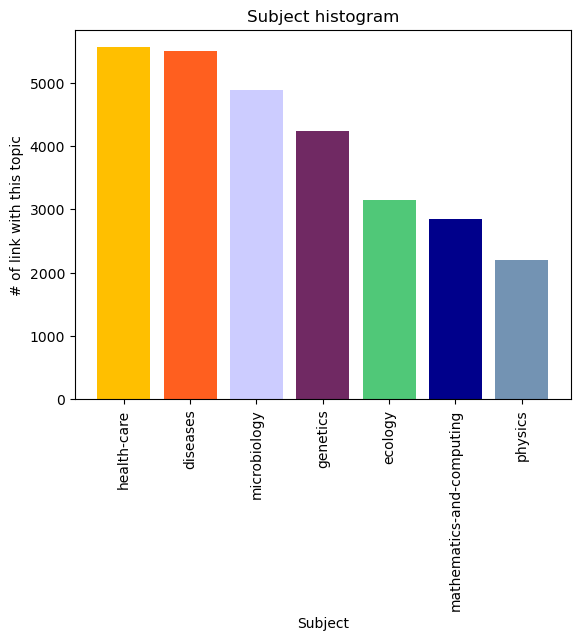

In [9]:
def subject_distribution(subjects, first_n):
    distrib = {}
    for subject, weight in subjects:
        if subject != 'All':
            distrib[subject] = distrib.get(subject,0) + weight
    width = 0.8 # width of the bars

    fig, ax = plt.subplots()

    ordered_items = sorted(distrib.items(),key=lambda x: x[1], reverse = True)[:first_n]
    xvalues = [subject for subject, value in ordered_items]
    yvalues = [value for subject, value in ordered_items]
    
    colors = [subj_color_mapping[subject] for subject in xvalues]

    rects1 = ax.bar(xvalues, yvalues, width, color=colors)
    ax.set_title("Subject histogram")
    ax.set_xlabel("Subject")
    ax.set_xticks(range(len(xvalues)),xvalues, rotation = 90) # set the position of the x ticks
    ax.set_ylabel("# of link with this topic")
    plt.show()


#Analyzing subjects
subjects = [(attr['subject'], attr['weight']) for node1, node2, attr in G.edges(data=True)]
first_n = 10
subject_distribution(subjects, first_n)
subject_set = set([subj for subj, weight in subjects])

Observing the histogram, it becomes evident that health-care and diseases and microbiology are the three prominent fields, followed by the clusters of ecology, genetics. In contrast, mathematics and physics exhibit a lower collaboration level. 

This leads us into thinking that the universities in field of physics and mathematics are collaborating less during 2023 than other fields.

__FUTURE WORK__: study the evolution over time of this plot, see if it has always been the case or not.

### 3.B. Creation of the subnetworks

Having gained a clearer understanding of the data distribution across subjects, our next step involves building subnetworks. Each subject will be represented as an individual network, and concurrently, we will create a comprehensive subnetwork encompassing all connections between universities, regardless of the subject. This approach allows us to explore both subject-specific collaborations and the overarching collaborative landscape across all subjects.

In [10]:
# Create a subgraph for a certain subject
def create_subgraph(G, subj):
    edges = set([(node1, node2, key) for node1, node2 in G.edges() for key, value in G.get_edge_data(node1, node2).items() if value['subject'] == subj])
    graph = G.edge_subgraph(edges)

    # Remove isolated nodes
    isolated_nodes = list(nx.isolates(graph))    
    if isolated_nodes:
        graph.remove_nodes_from(isolated_nodes)

    return graph
    

We can now use the utility function to save all the graphs in a dictionary.

In [11]:
graphs = {}
for subj in subj_color_mapping.keys():
    graphs[subj] = create_subgraph(G, subj)

### 3.C. Creation of the degree distributions

Subsequently, we can access the desired graphs through the 'graphs' dictionary. Our next objective is to generate the corresponding degree distributions for each graph within this dictionary. 

Since we are in a graph with weighted edges, the degree of a node is the sum of the weights of all the edges incident to that node.

In [12]:
# Get the degree of a node
def get_node_degree(graph, node):
    sum = 0
    for fr, to, d in graph.edges(node, data=True):
        sum = sum + d['weight']
    return sum

In [13]:
degrees = {}
sorted_degrees = {}
for subj in graphs:
    degrees[subj] = [(n, graphs[subj].nodes[n]['country'], get_node_degree(graphs[subj], n)) for n in graphs[subj].nodes]
    sorted_degrees[subj] = sorted(degrees[subj], key=lambda x: x[2], reverse=True)

## 4. Analysis of the subnetworks

Now that we have access to both graphs and degree distributions, we can start the analysis of networks to uncover any noteworthy patterns.

### Utilities functions for analysis

To facilitate this analysis, we'll begin by creating two utility functions – one for populate bar charts and another for rendering network visualizations and bar charts for each subject. These functions will serve as valuable tools in our exploration of potential patterns within the collaborative networks.

In [14]:
def populate_plot(data, subj, fig, grid, labels):
    dmax = max(data[:])
    dmin = min(data[:])
    
    #Bin plot
    bins = np.arange(dmin, dmax+2)
    hist, bins = np.histogram(data[:], bins)
    
    ax = fig.add_subplot(grid) 
    ax.bar(bins[:-1], hist, width=1, align='center', edgecolor='k', color = subj_color_mapping[subj])
    ax.set_title(f'{subj}')
    ax.set_xlabel(labels['xlabel'])
    ax.set_ylabel('How many')
    return ax

In [15]:
def drawLogLogPoints(data, subj, fig, grid, labels):
    dmax = max(data[:])
    dmin = min(data[:])
    
    #Bin plot
    bins = np.arange(dmin, dmax+2)
    hist, bins = np.histogram(data[:], bins)
    
    ax = fig.add_subplot(grid) 
    ax.loglog(bins[:-1], hist,'o', color = subj_color_mapping[subj])
    ax.set_title(f'{subj}')
    ax.set_xlabel(labels['xlabel'])
    ax.set_ylabel('How many')
    return ax

In [16]:
#Only requires subject associated with list of data to barplot
def create_visual_graph(subj_data_dict, labels, category='bar'):
    fig = plt.figure("Distribution", figsize=(15, 30))
    
    # Create a gridspec for adding subplots of different sizes
    axgrid = fig.add_gridspec(4, 2)
    
    axes = []
    for i, grid in enumerate(axgrid):
        if category == 'bar':
            axes.append(populate_plot(list(subj_data_dict.values())[i], list(subj_data_dict.keys())[i], fig, grid, labels))
        if category == 'network2d':
            axes.append(drawNetwork2D(list(subj_data_dict.values())[i], list(subj_data_dict.keys())[i], fig, grid, labels))
        if category == 'network3d':
            graph = list(subj_data_dict.values())[i].subgraph(sorted(nx.connected_components(list(subj_data_dict.values())[i]), key=len, reverse=True)[0])
            positions = nx.spring_layout(graph, k=1.2, scale=8)
            axes.append(drawNetwork3D(graph, positions=positions, fig=fig, grid=grid, name=labels[i]))
        elif category == 'loglog':
            axes.append(drawLogLogPoints(list(subj_data_dict.values())[i], list(subj_data_dict.keys())[i], fig, grid, labels))
    
    fig.tight_layout()
    plt.show()

### Count of Nodes and Edges and top 3 universities

To start our analysis, we'll start by examining the number of nodes and edges within each subnetwork. This initial exploration will provide us with fundamental insights into the structure and scale of each collaborative network

In [17]:
for subj in graphs:
    graph = graphs[subj]
    print(f"Graph on \033[1m{subj}\033[0m has {len(graph.nodes())} nodes and {len(graph.edges())} edges.")

Graph on health-care has 871 nodes and 4358 edges.
Graph on mathematics-and-computing has 634 nodes and 2410 edges.
Graph on genetics has 662 nodes and 3210 edges.
Graph on ecology has 703 nodes and 2766 edges.
Graph on diseases has 789 nodes and 4426 edges.
Graph on microbiology has 744 nodes and 3656 edges.
Graph on physics has 599 nodes and 1896 edges.
Graph on All has 3283 nodes and 20750 edges.


We can now get the top 3 universities for each subject.

In [18]:
for subj in graphs:
    print(f"Top 3 universities \033[1m({subj})\033[0m:")
    for i, (name, country, degree) in enumerate([(name, country, degree) for name, country, degree in sorted_degrees[subj]][:3], 1):
        print(f"{i}. University: {name} ({country}), Number of collaborations: {degree}")
    print("")

Top 3 universities (health-care):
1. University: Seoul National University Hospital (South Korea), Number of collaborations: 113
2. University: Lithuanian University of Health Sciences (Lithuania), Number of collaborations: 101
3. University: Dankook University College of Medicine (South Korea), Number of collaborations: 99

Top 3 universities (mathematics-and-computing):
1. University: King Saud University (Saudi Arabia), Number of collaborations: 152
2. University: Lebanese American University (Lebanon), Number of collaborations: 138
3. University: University College London (United Kingdom), Number of collaborations: 105

Top 3 universities (genetics):
1. University: Tampere University (Finland), Number of collaborations: 107
2. University: University of Helsinki (Finland), Number of collaborations: 106
3. University: University of California (United States), Number of collaborations: 103

Top 3 universities (ecology):
1. University: University of California (United States), Number o

The first thing we directly remark is, of course, that the University of Copenhagen is the second in ecology and the University of Southern Denarmk is the third in ecology (wouhou!).

Interestingly, MIT is conspicuously absent from the top 3 in any section, in contrast to the noteworthy presence of Saudi Arabian universities in these leading positions.

It's crucial to acknowledge that collaboration rankings are subject to fluctuations based on the dataset and the specific timeframe. In this case, our analysis is confined to nature.com articles from the year 2023.

Regarding MIT, potential reasons for its absence might extend beyond a preference for solo study. Factors such as specific research focuses, international collaboration strategies, or the nature of collaborations pursued by MIT could be contributing to the observed pattern.

### Degree distributions

Let's now draw all the degree distributions:

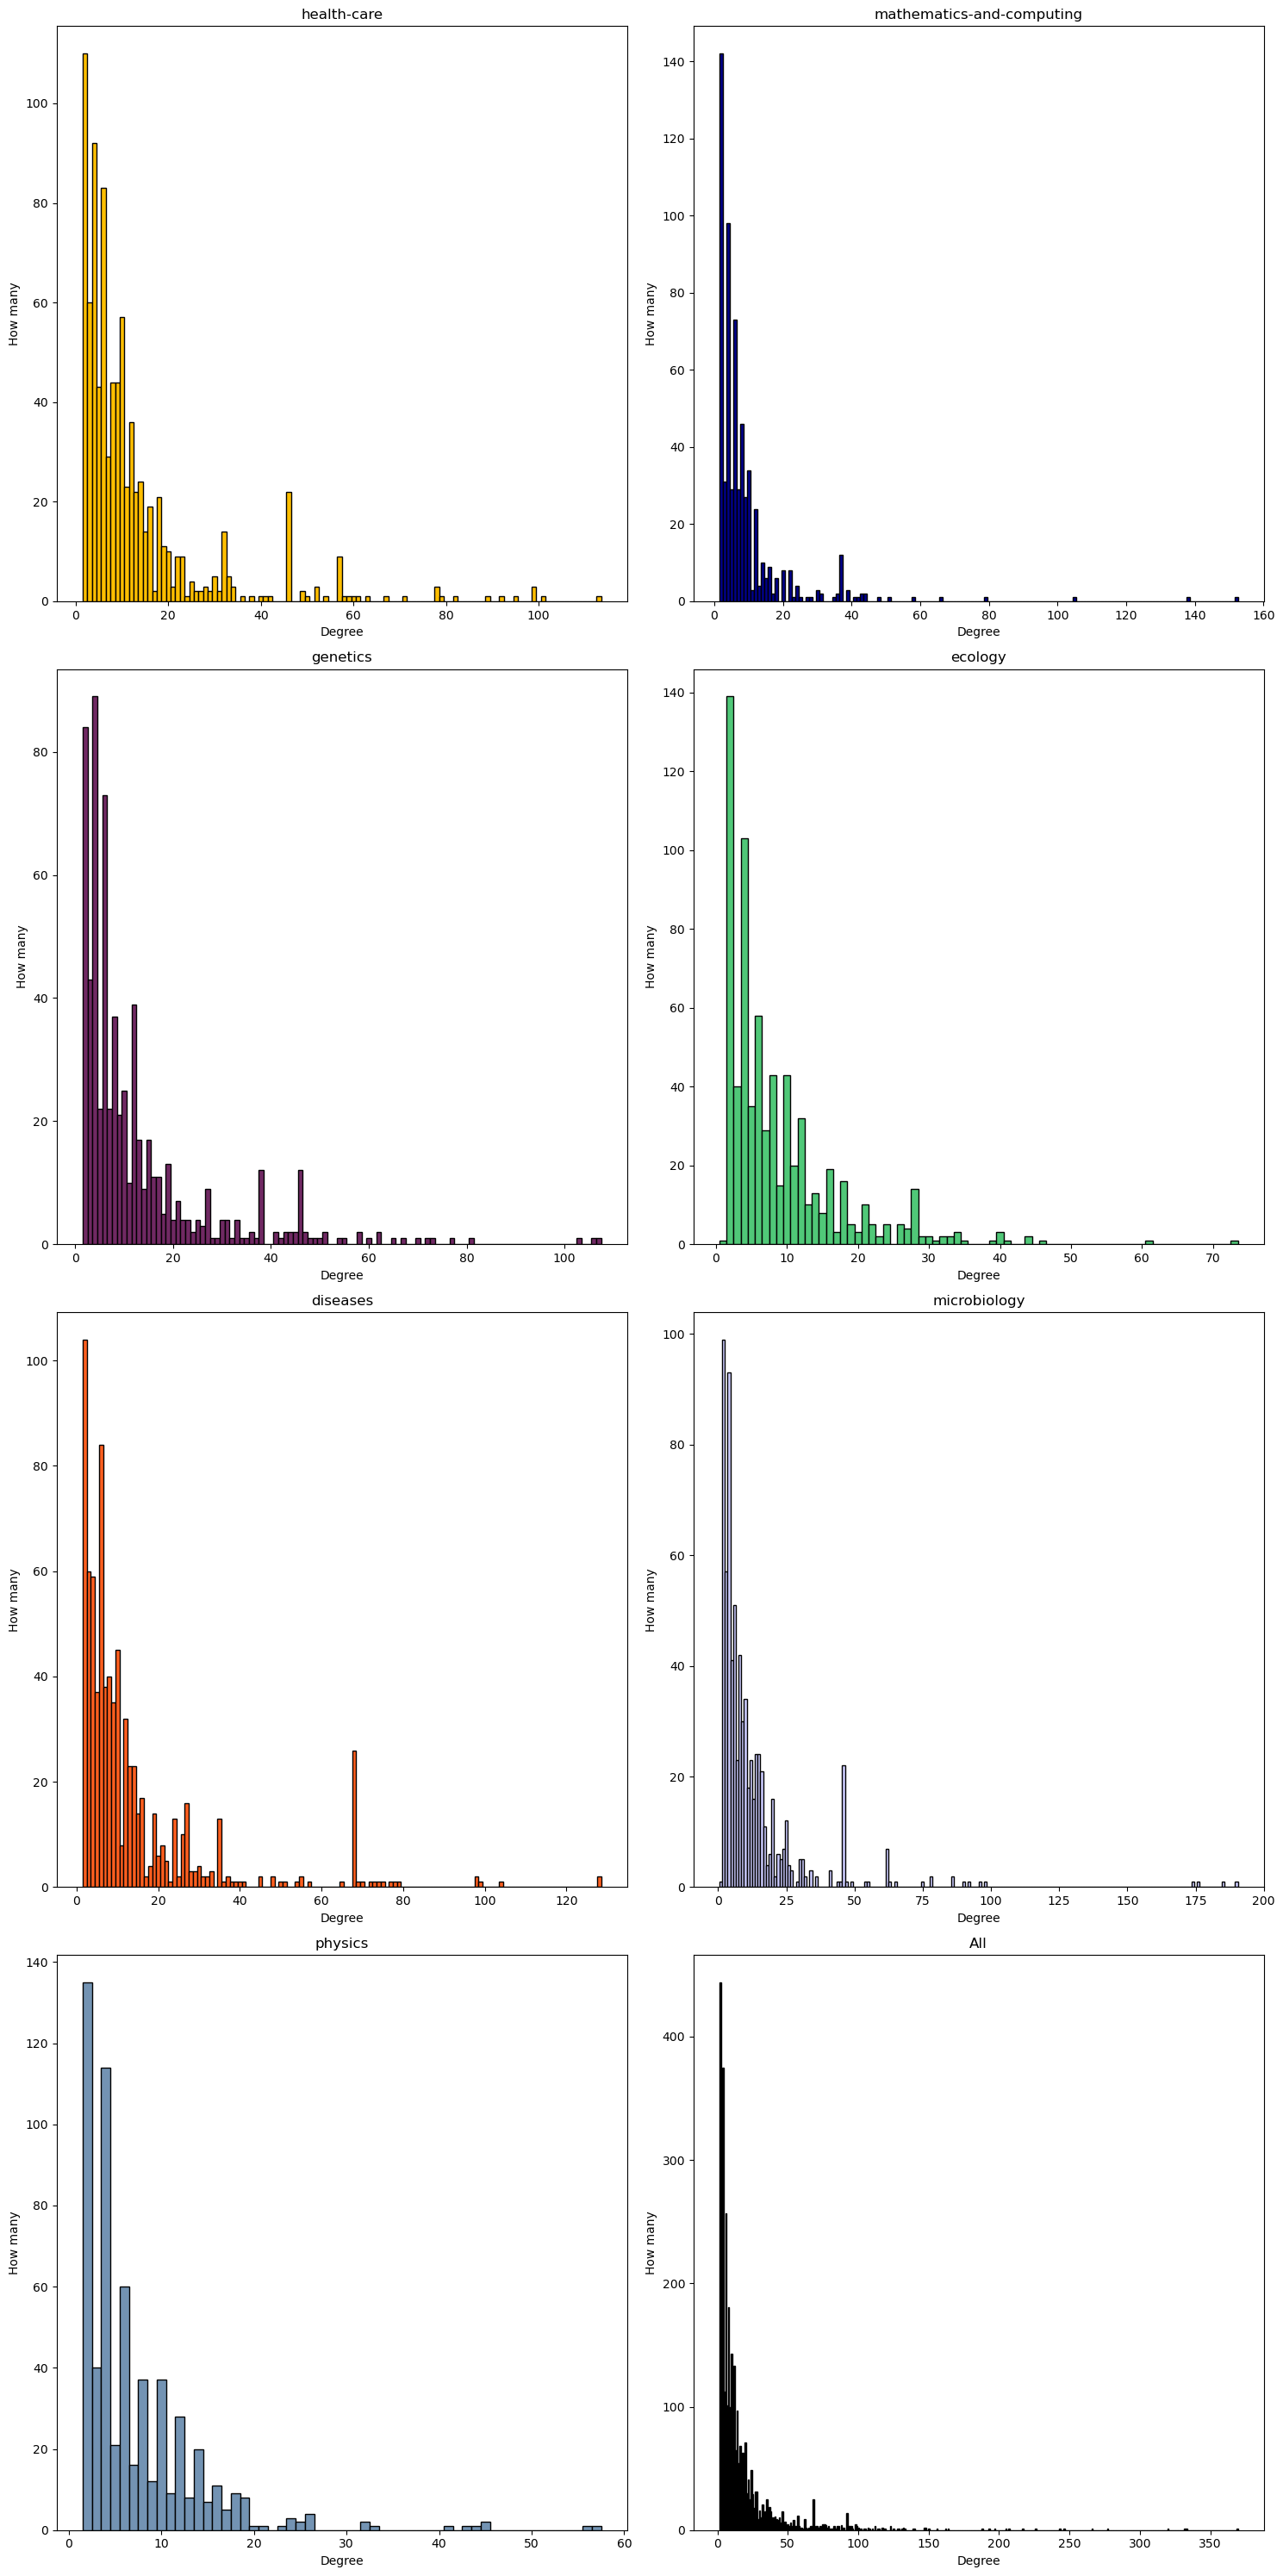

In [19]:
subj_degrees_dict = {}
labels = {'xlabel':'Degree'}
for subject, graph in graphs.items():
    subj_degrees_dict[subject] = list(map(lambda x: x[2], sorted_degrees[subject]))
    
create_visual_graph(subj_degrees_dict, labels, 'bar')

What is interesting to see is that all distributions exhibit an alternating behaviour, where nodes with even degrees are very frequent while nodes with odd degrees aren't as much. This provides insights about universities cooperation: considering many researchers of the same paper can be from the same university, it is probably harder to work in cluster of 4,6,8 universities and so on. 

Disregarding this alternating behaviour, the distribution overall seems to have exponential shape, with very few nodes having a high degree(hubs). We will check properties of these networks in the following section.

### Checking scale-freeness

##### Log-Log plot

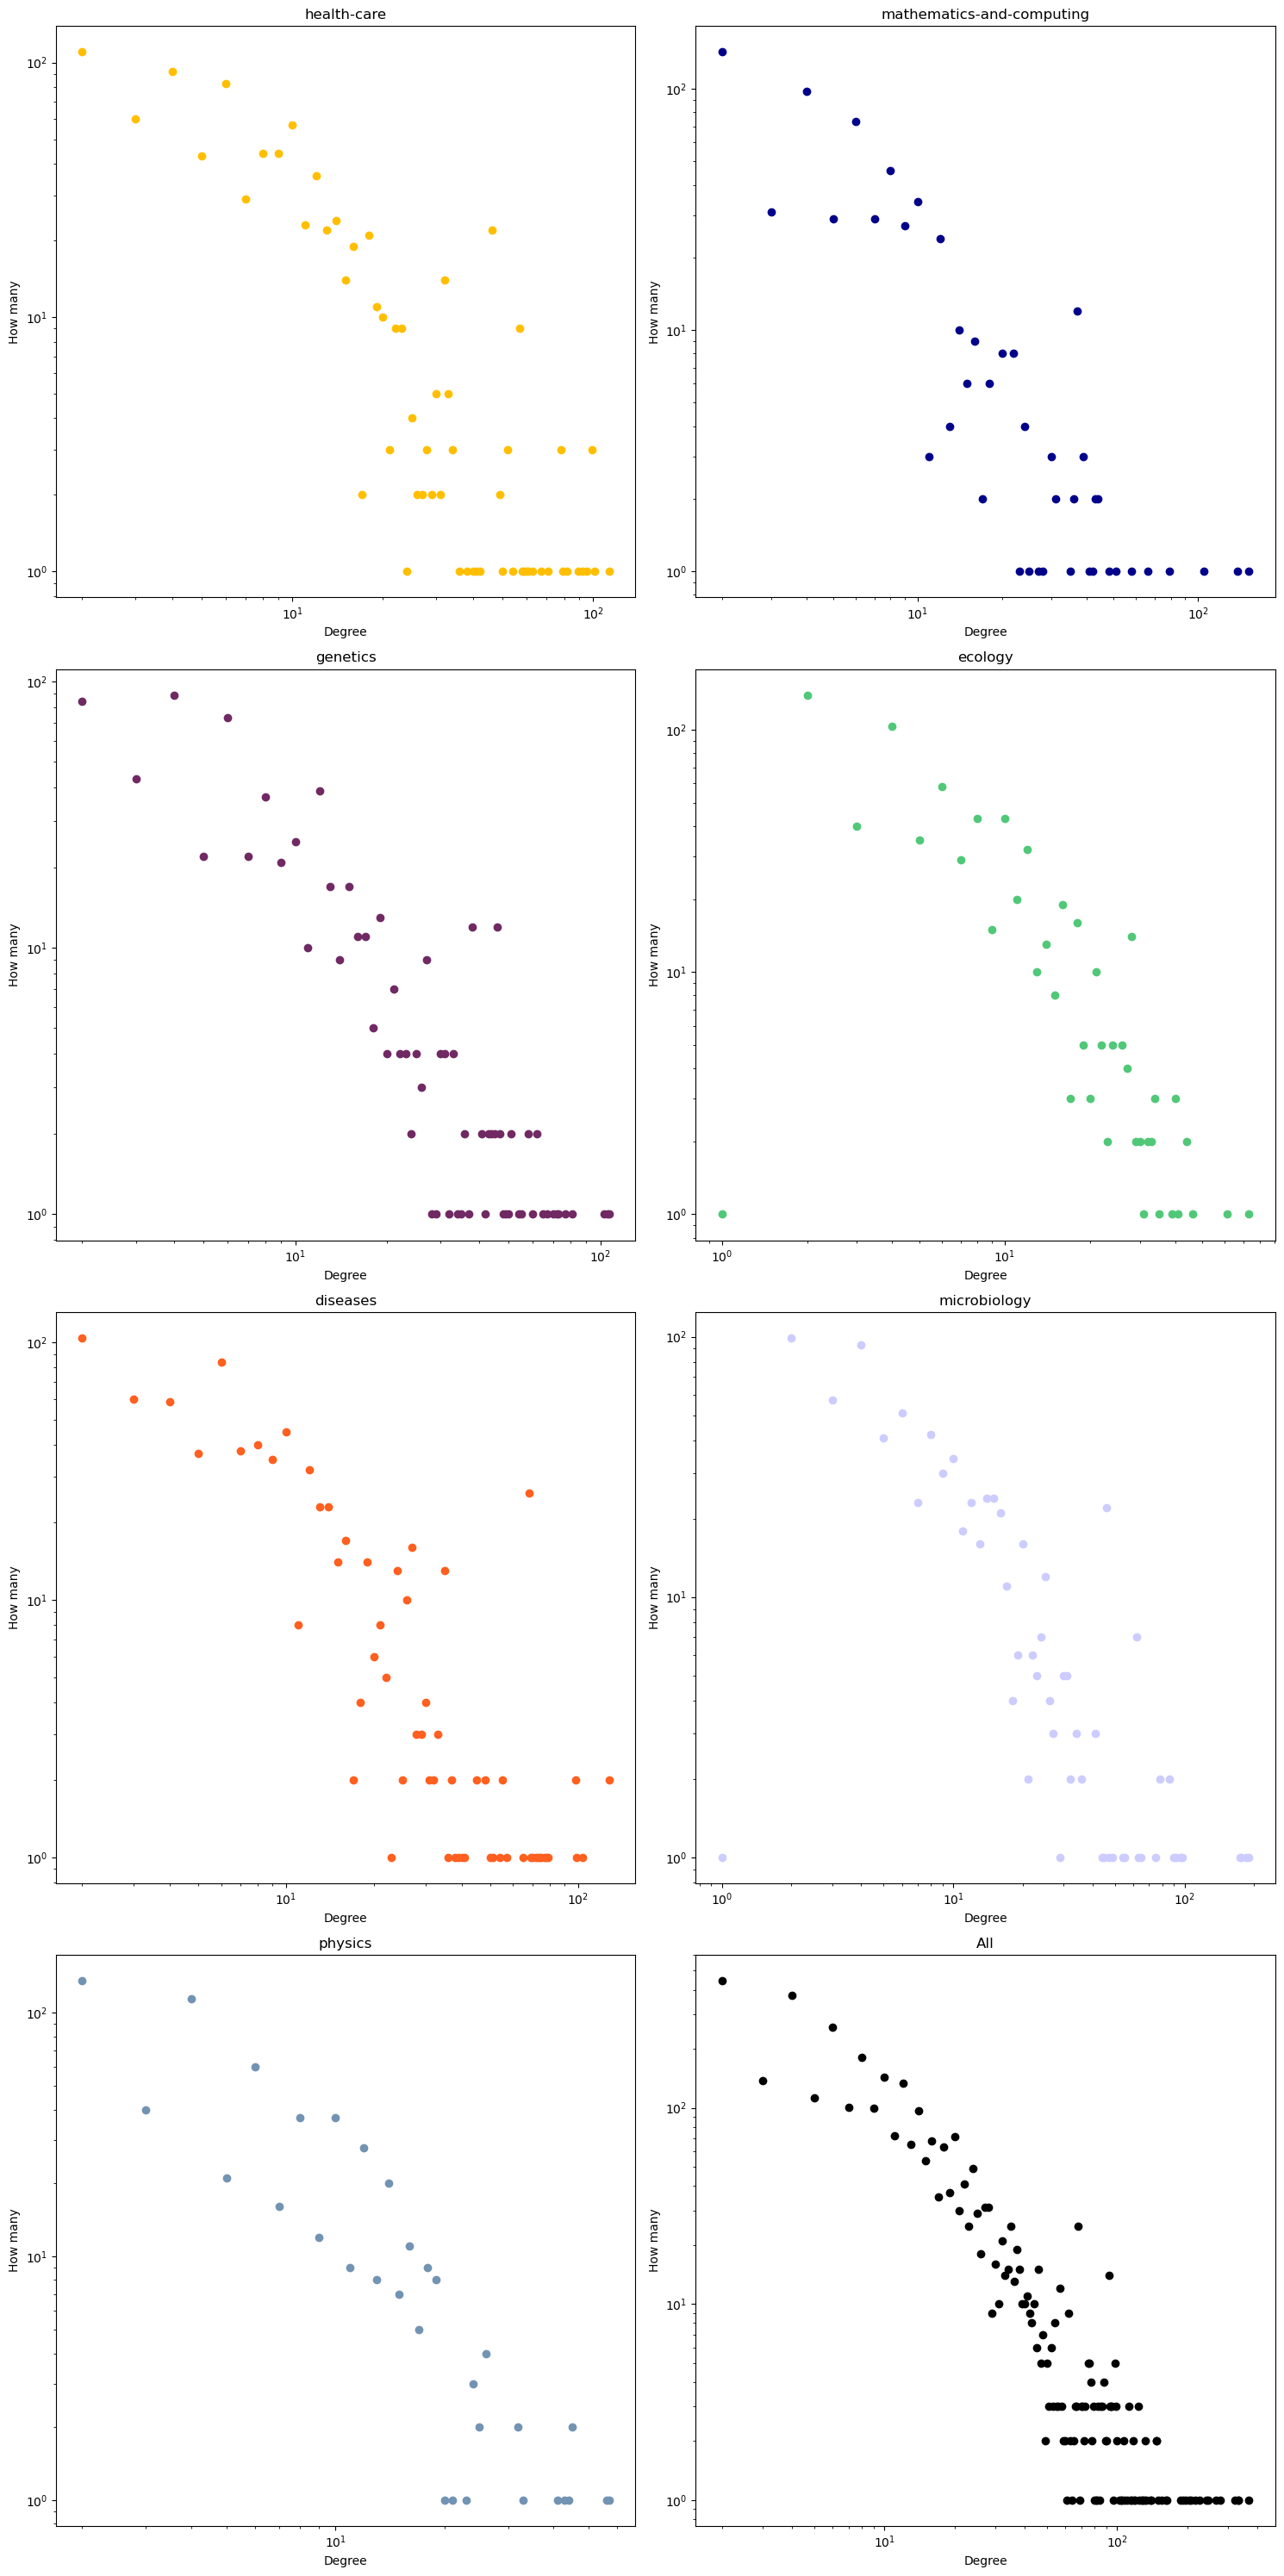

In [20]:
create_visual_graph(subj_degrees_dict, labels, 'loglog')

##### Checking nodes assortativity, with and without country differentiation

In [21]:
#Degree assortativity
for subj, graph in graphs.items():
    print(f'Subj \033[1m{subj}\033[0m:')
    degree_assortativity = nx.degree_assortativity_coefficient(graph)
    print(f"\tDegree assortativity: {degree_assortativity}")

    #Country assortativity
    country_assortativity = nx.attribute_assortativity_coefficient(graph, 'country')
    print(f"\tCountry assortativity: {country_assortativity}")

Subj health-care:
	Degree assortativity: 0.826436167369785
	Country assortativity: 0.5326103772045011
Subj mathematics-and-computing:
	Degree assortativity: 0.24504083016675476
	Country assortativity: 0.3602067043620808
Subj genetics:
	Degree assortativity: 0.5652346258617666
	Country assortativity: 0.575697560040668
Subj ecology:
	Degree assortativity: 0.4437038462899302
	Country assortativity: 0.3791578331850312
Subj diseases:
	Degree assortativity: 0.8333507525384372
	Country assortativity: 0.7059767177206726
Subj microbiology:
	Degree assortativity: 0.6475523796791943
	Country assortativity: 0.41516904086040646
Subj physics:
	Degree assortativity: 0.2937905758491027
	Country assortativity: 0.40564228431679306
Subj All:
	Degree assortativity: 0.13872403042566125
	Country assortativity: 0.5288447940858454


A positive assortativity coefficient indicates assortative mixing, while a negative coefficient suggests disassortative mixing, where nodes tend to connect to nodes with different characteristics.

We can see from the above results that in general, nodes in our networks have a quite strong tendency to connect with nodes with similar degrees. These means that hubs connect to each other, possibly leading to small world properties. Also, because of this, we can say that our network is most likely not a scale-free network. This is an expected result, given what's written in __Quote PAPER Found__.

Additionally, nodes tend to link with other nodes from the same country.

#### Verifying small world property: Average shortest path

Here, we compute the average shortest path to verify if the network exhibits small world properties

In [22]:
for subj, graph in graphs.items():
    Gcc = sorted(nx.connected_components(graph), key=len, reverse=True)[0]
    connected_graph = graph.subgraph(Gcc).copy()
    asp = nx.average_shortest_path_length(connected_graph, weight='weight')
    print(f"Subject \033[1m{subj}\033[0m has average shortest path: {asp}")

Subject health-care has average shortest path: 9.829029568165351
Subject mathematics-and-computing has average shortest path: 3.6018705151979358
Subject genetics has average shortest path: 5.920132714001327
Subject ecology has average shortest path: 5.708315243039169
Subject diseases has average shortest path: 3.5902702702702705
Subject microbiology has average shortest path: 4.875022926525072
Subject physics has average shortest path: 8.511937946915525
Subject All has average shortest path: 5.297589832985943


All the subnetwork exhibit low average short distances

##### Clustering coefficent

In [23]:
for subj, graph in graphs.items():
    undirected = nx.Graph(graph)
    ac = nx.average_clustering(undirected, weight='weight')
    print(f"Subject \033[1m{subj}\033[0m has average clustering coefficent of: {ac}")

Subject health-care has average clustering coefficent of: 0.08110755658661267
Subject mathematics-and-computing has average clustering coefficent of: 0.1125611887441611
Subject genetics has average clustering coefficent of: 0.08130957055637171
Subject ecology has average clustering coefficent of: 0.16533665892005567
Subject diseases has average clustering coefficent of: 0.05977575659761924
Subject microbiology has average clustering coefficent of: 0.083509134039795
Subject physics has average clustering coefficent of: 0.044997953795782496
Subject All has average clustering coefficent of: 0.0252956309710316


##### Friendship paradox

In [24]:
#Friendship part

iterations = 1000
for subj, graph in graphs.items():
    count_f_paradox = 0
    for i in range(iterations):
        random_node = random.choice(list(graph.nodes()))
        random_node_degree = graph.degree[random_node]
        random_node_neighbors = list(graph.neighbors(random_node))
        #print(random_node_degree, random_node_neighbors)
        avg_neighbor_degree =  []

        for neighbor in random_node_neighbors:
            avg_neighbor_degree.append(graph.degree[neighbor])
        avg_neighbor_degree = sum(avg_neighbor_degree)/len(avg_neighbor_degree)

        if avg_neighbor_degree > len(random_node_neighbors):
            count_f_paradox+=1
    print(f"Subject \033[1m{subj}\033[0m: out of {iterations} tests, the paradox is true {count_f_paradox} times")

Subject health-care: out of 1000 tests, the paradox is true 976 times
Subject mathematics-and-computing: out of 1000 tests, the paradox is true 980 times
Subject genetics: out of 1000 tests, the paradox is true 979 times
Subject ecology: out of 1000 tests, the paradox is true 972 times
Subject diseases: out of 1000 tests, the paradox is true 973 times
Subject microbiology: out of 1000 tests, the paradox is true 983 times
Subject physics: out of 1000 tests, the paradox is true 977 times
Subject All: out of 1000 tests, the paradox is true 960 times


##### Exponent using the powerlaw package

Let's now try to find the exponent of the degree distributions for each subject.

In [25]:
for subj in graphs:
    # Fit the power-law distribution
    fit = powerlaw.Fit(list(map(lambda x: x[2], degrees[subj])), verbose=False)
    exponent = fit.alpha
    print(f"Powerlaw of \033[1m{subj}\033[0m is {fit.alpha}");

Powerlaw of health-care is 2.484054499670166
Powerlaw of mathematics-and-computing is 2.7495824455033198
Powerlaw of genetics is 2.4635259479404867
Powerlaw of ecology is 3.1037893103509333
Powerlaw of diseases is 2.3120342520139934
Powerlaw of microbiology is 2.5686303512771396
Powerlaw of physics is 4.264732201385063
Powerlaw of All is 2.457913145830589


c:\Users\floco\anaconda3\lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


The power-law results offer valuable insights into the distribution of collaborations among universities in diverse academic disciplines. The consistently high exponents observed in fields such as Health Care, Microbiology, and Physics indicate a significant concentration of collaborative activities among a few key institutions. This suggests a pattern where certain universities play pivotal roles in fostering collaborations within these disciplines. On the other hand, the lower exponents in Ecology and the overarching "All" category suggest a more evenly spread distribution of collaborations, implying a broader engagement across a wider array of institutions in these areas.

__QUOTE 4.7 barabasi book__

### Connected components

Let's now focus on the connected component, we can try to print the connected component size distribution for each subject.

In [26]:
##How many connected components? And how big are they?
def connected_component_size_distribution(G, subj):
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    print(f"Subject \033[1m{subj}\033[0m has {len(Gcc)} connected components")
    Gcc_len_distrib = [len(cc) for cc in Gcc]
    return Gcc_len_distrib

Subject health-care has 147 connected components
Subject mathematics-and-computing has 131 connected components
Subject genetics has 114 connected components
Subject ecology has 119 connected components
Subject diseases has 138 connected components
Subject microbiology has 128 connected components
Subject physics has 126 connected components
Subject All has 223 connected components


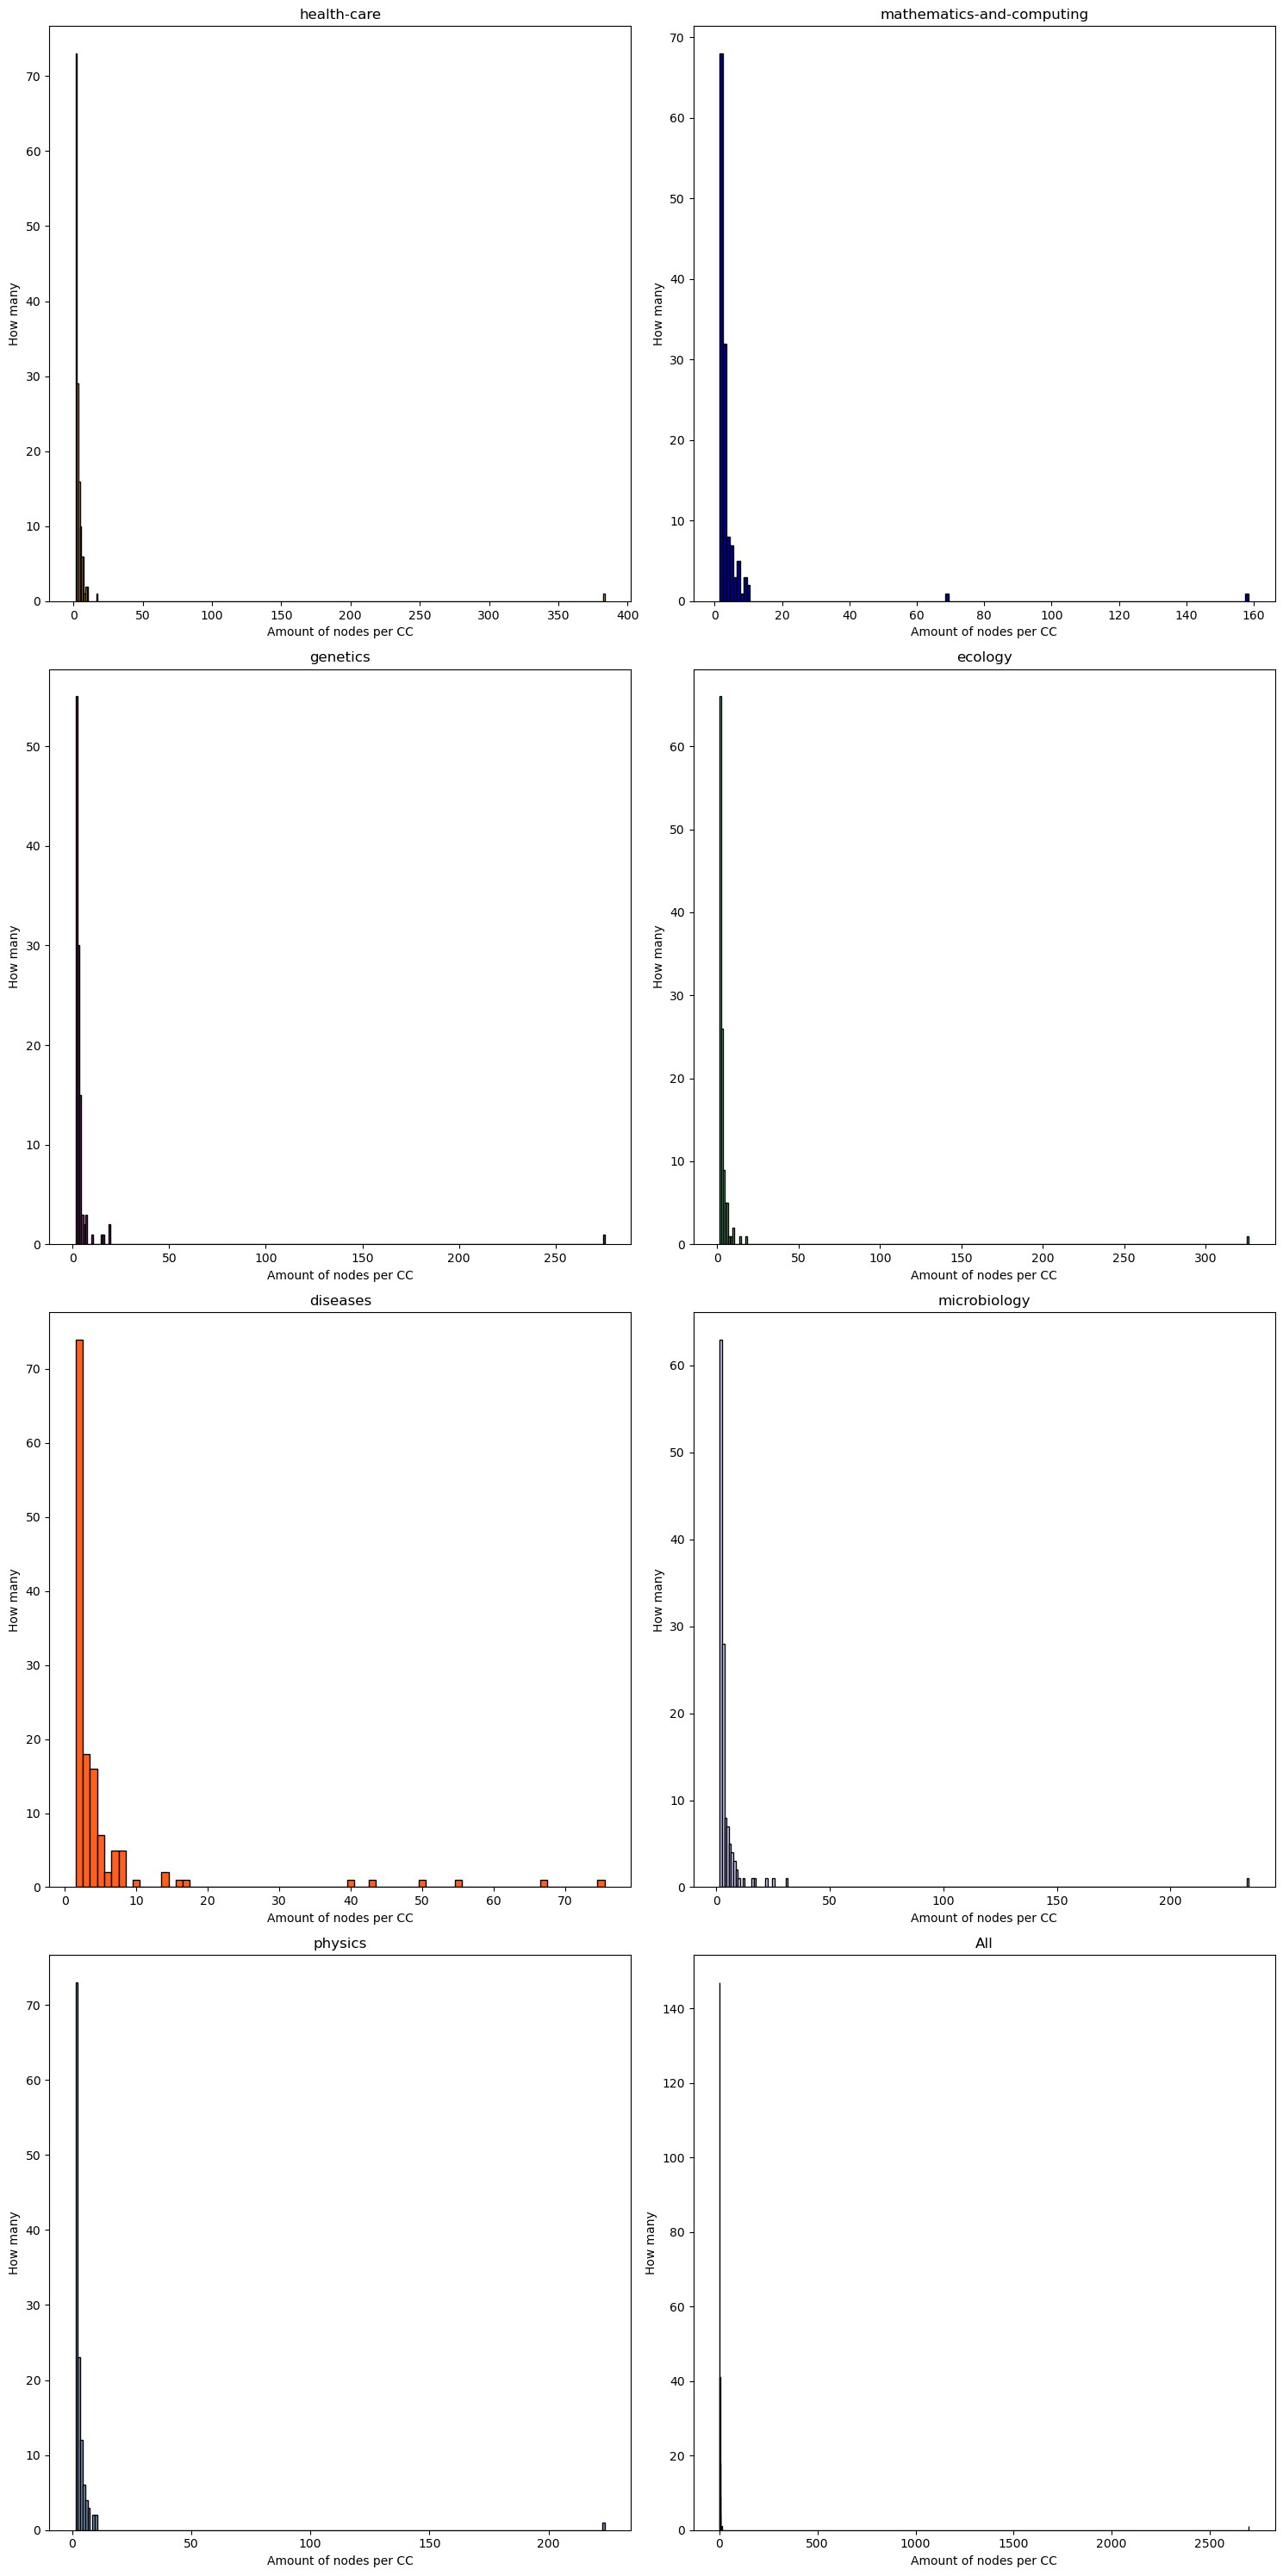

In [27]:
subj_cc_size_dict = {}
labels = {'xlabel':'Amount of nodes per CC'}
for subject, graph in graphs.items():
    subj_cc_size_dict[subject] = connected_component_size_distribution(graph, subject)

create_visual_graph(subj_cc_size_dict, labels, 'bar')

We can see that in most cases, there is a component that far exceeds the others in terms of size 

### Universities centrality

We will now start answering our question using __network centrality__. So, we are now going to investigate which universities are most central in our network, and therefore which country has the highest mean centrality with respect to a particular field.

##### Degree centrality

In [28]:
def compute_degree_centrality(G, subj, n_first):
    centrality = nx.degree_centrality(G)
    centrality_list = sorted(centrality.items(), key=lambda x: x[1], reverse=True)
    
    if n_first != 0:
        most_central_universities = centrality_list[:n_first]
        print(f"Most central uni's of \033[1m{subj}\033[0m")
        pprint(most_central_universities)
        print("\n")
    
    return centrality

In [29]:
degree_centralities = {}

n_first = 3
for subj, graph in graphs.items():
    degree_centralities[subj] = compute_degree_centrality(graph, subj, n_first)

Most central uni's of health-care
[('Lithuanian University of Health Sciences', 0.0735632183908046),
 ('Seoul National University College of Medicine', 0.06666666666666667),
 ('Seoul National University Hospital', 0.06666666666666667)]


Most central uni's of mathematics-and-computing
[('Lebanese American University', 0.16113744075829384),
 ('King Saud University', 0.14533965244865718),
 ('Future University in Egypt', 0.08846761453396525)]


Most central uni's of genetics
[('University of California', 0.13313161875945537),
 ('Broad Institute of MIT and Harvard', 0.09682299546142209),
 ('University of Michigan', 0.08472012102874432)]


Most central uni's of ecology
[('University of Copenhagen', 0.07692307692307693),
 ('University of California', 0.06837606837606838),
 ('University of Southern Denmark', 0.05982905982905983)]


Most central uni's of diseases
[('Peking Union Medical College Hospital', 0.09137055837563451),
 ('Shengjing Hospital of China Medical University', 0.0888324873096

##### Betweennes centrality

In [30]:
def compute_betweenness_centrality(G, subj, n_first):
    centrality = nx.betweenness_centrality(G, weight='weight', seed=12345)
    centrality_list = sorted(centrality.items(), key=lambda x: x[1], reverse=True)
    
    if n_first != 0:
        most_central_universities = centrality_list[:n_first]
        print(f"Most central uni's of \033[1m{subj}\033[0m")
        pprint(most_central_universities)
        print("\n")
        
    return centrality

In [31]:
betweenness_centralities = {}

n_first = 3
for subj, graph in graphs.items():
    betweenness_centralities[subj] = compute_betweenness_centrality(graph, subj, n_first)

Most central uni's of health-care
[('University of Pennsylvania', 0.08991706678306416),
 ('University of California', 0.08939902797966318),
 ('Harvard University', 0.08390407788050738)]


Most central uni's of mathematics-and-computing
[('Lebanese American University', 0.022924206991740605),
 ('King Saud University', 0.01623255790206065),
 ('Taif University', 0.009975587697916965)]


Most central uni's of genetics
[('University of Southern California', 0.0721856402315303),
 ('University of Lausanne', 0.06998464218585247),
 ('University of Bologna', 0.06670792646586898)]


Most central uni's of ecology
[('University of Copenhagen', 0.07853839372033936),
 ('Universidade de Lisboa', 0.044732004792820156),
 ('University of Southern Denmark', 0.044698688894115636)]


Most central uni's of diseases
[('University of Oxford', 0.00370068562159279),
 ('Mahidol University', 0.003250073580807002),
 ('Harvard Medical School', 0.002271940569401208)]


Most central uni's of microbiology
[('Liverpool 

In [32]:
# Create a scatter plot to compare centrality measures
def compare_centrality_scatter(ax, centrality1, centrality2, labels, subj):
    x = [centrality1[node] for node in centrality1]
    y = [centrality2[node] for node in centrality2]

    ax.scatter(x, y, alpha=0.5)
    ax.set_title(f'Comparison of Centrality Measures - {subj}')
    ax.set_xlabel('Betweenness Centrality')
    ax.set_ylabel('Degree Centrality')

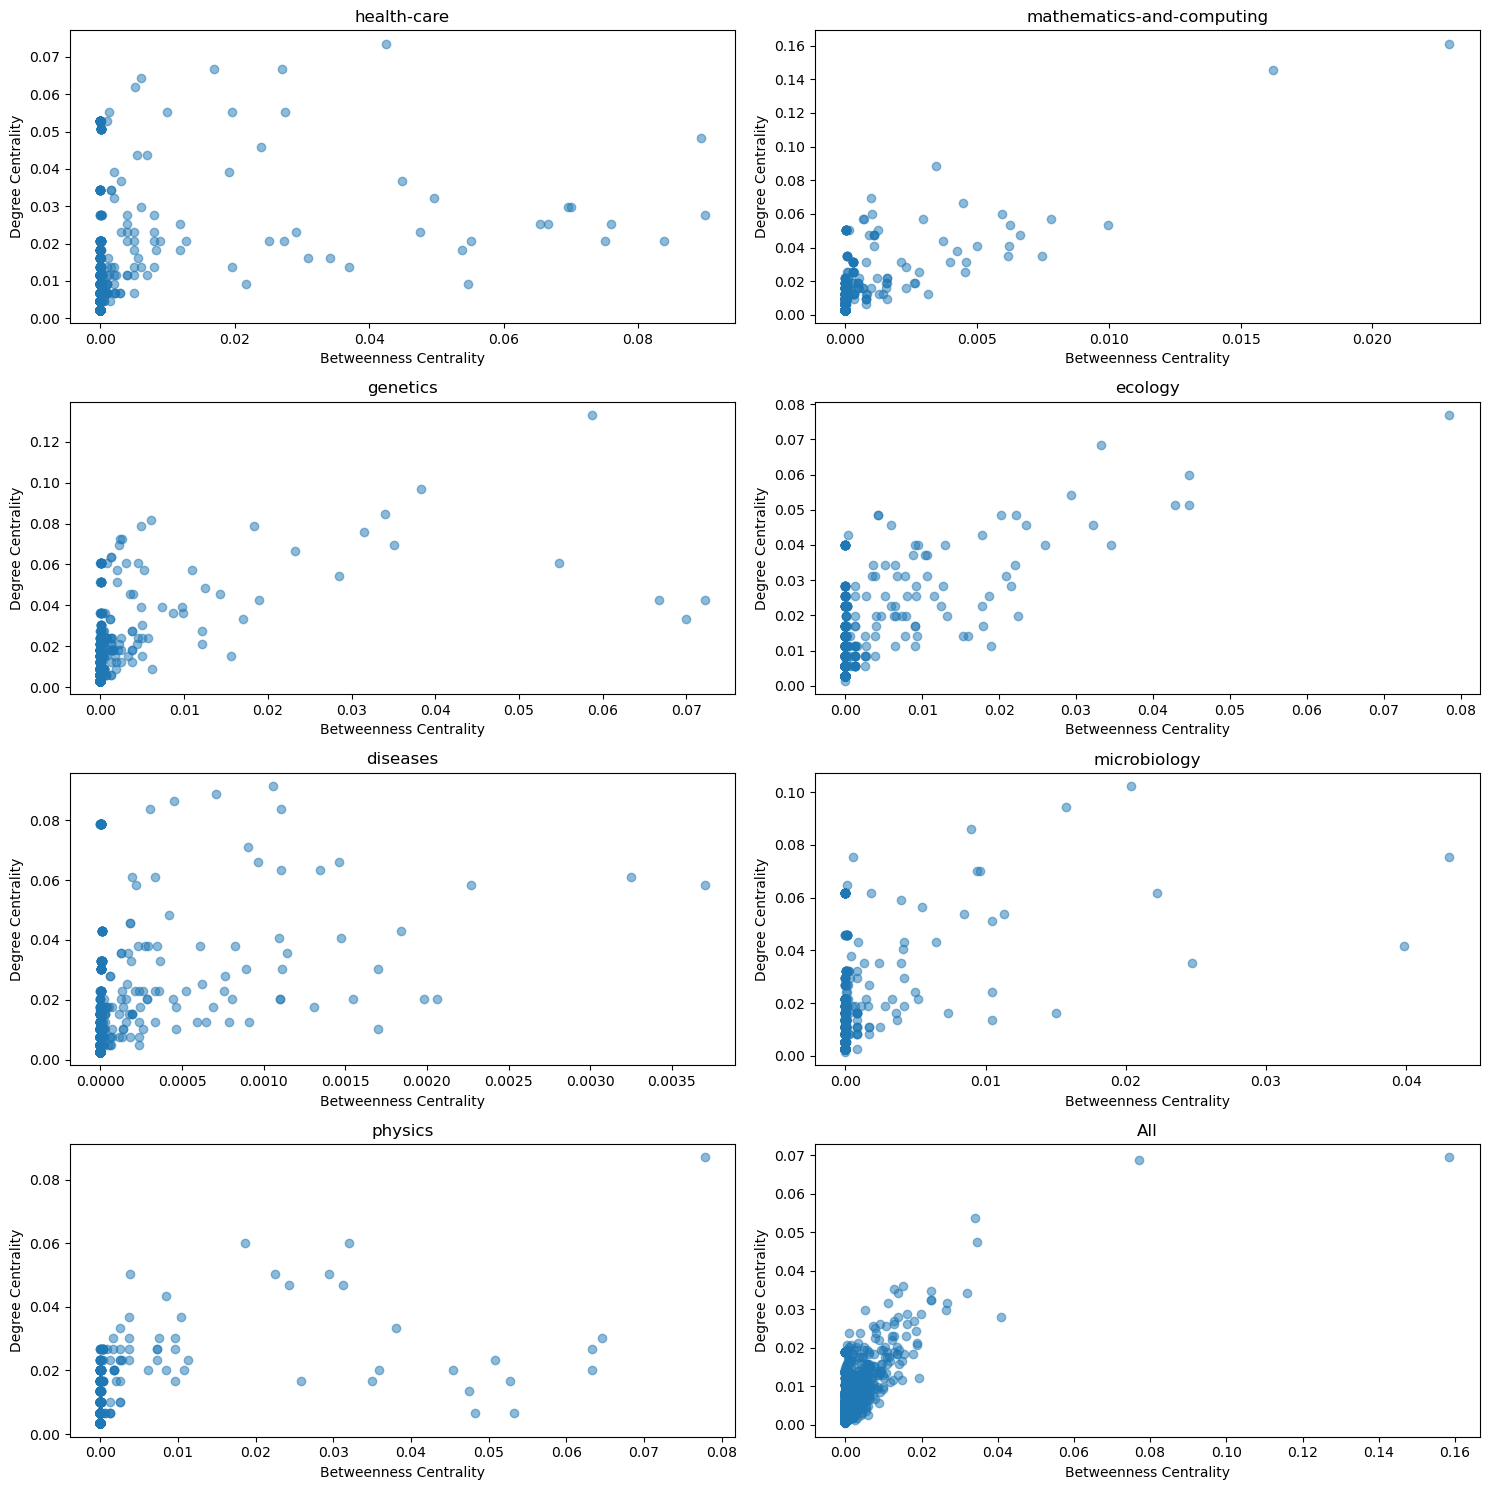

In [33]:
# Assuming `graphs` is a dictionary with subjects as keys and corresponding graphs as values
fig, axs = plt.subplots(4, 2, figsize=(15, 15))

for i, (subj, graph) in enumerate(graphs.items()):
    betweenness_centrality_data = betweenness_centralities[subj]
    degree_centrality_data = degree_centralities[subj]

    # Calculate subplot position
    row = i // 2
    col = i % 2

    # Create subplots
    ax = axs[row, col]
    compare_centrality_scatter(ax, betweenness_centrality_data, degree_centrality_data, labels=list(graph.nodes), subj=subj)
    ax.set_title(subj)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


### Countries Centrality

In [ ]:
country_edges = {}
country_graphs = {}
for subj, graph in graphs.items():
    for node1, node2, attr in graph.edges(data=True):
        country1 = graph.nodes[node1]['country']
        country2 = graph.nodes[node2]['country']
        country_edges[(country1,country2)] = country_edges.get((country1, country2),0)+attr['weight']
        
    country_edges_input = [(u,v,{'weight':k}) for (u,v),k in country_edges.items()]
    country_graph = nx.Graph()
    country_graph.add_edges_from(country_edges_input)
    country_graphs[subj] = country_graph.copy()

In [ ]:
for subj, graph in country_graphs.items():
    graph.remove_edges_from(list(nx.selfloop_edges(graph)))

### Countries Centrality

##### Degree centrality according to country (average)

In [34]:
country_degree_centralities = {}

n_first = 3
for subj, graph in country_graphs.items():
    country_degree_centralities[subj] = compute_degree_centrality(graph, subj, n_first)

NameError: name 'country_graphs' is not defined

##### Betweenness centrality according to country (average)

In [ ]:
country_betweenness_centralities = {}

n_first = 3
for subj, graph in country_graphs.items():
    country_betweenness_centralities[subj] = compute_betweenness_centrality(graph, subj, n_first)

##### Scatter plot according to country centrality

In [ ]:
# Assuming `graphs` is a dictionary with subjects as keys and corresponding graphs as values
fig, axs = plt.subplots(4, 2, figsize=(15, 15))

for i, (subj, graph) in enumerate(country_graphs.items()):
    country_betweenness_centrality_data = country_betweenness_centralities[subj]
    country_degree_centrality_data = country_degree_centralities[subj]

    # Calculate subplot position
    row = i // 2
    col = i % 2

    # Create subplots
    ax = axs[row, col]
    compare_centrality_scatter(ax, country_betweenness_centrality_data, country_degree_centrality_data, labels=list(country_graph.nodes), subj=subj)
    ax.set_title(subj)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

TODO: Comments about centrality

## Part 5: Networks plotting

Now, we'll attempt to visualize our network in both 2D and 3D. 
To facilitate this, we'll begin by defining some utility functions.

### Utilities functions

In [ ]:
# Generate colors for x countries
def get_color_map(top_countries):
    dict_color = {}
    colors = plt.cm.get_cmap('hsv', len(top_countries) + 2)
    
    for i, d in enumerate(top_countries):
        dict_color[d] = colors(i)
    
    dict_color['other'] = colors(len(top_countries))

    return dict_color

In [ ]:
# Get the 10 biggest countries
def get_10_biggest_countries(subj):
    countries_count = {}
    while len(countries_count) < 10:
        for n, c, w in sorted_degrees[subj]:
            if c not in countries_count:
                countries_count[c] = 0
            countries_count[c] += 1
            
            if len(countries_count) >= 10:
                break
    
    return list(map(lambda x: x[0], sorted(countries_count.items(), key=lambda x:x[1], reverse=True)[:8]))

### 2D Networks plotting

In [ ]:
def drawNetwork2D(G, subj, fig, grid, labels, scaling_factor=1):   
    #We draw only the biggest component/we should use the biggest component in general
    Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
        
    #color_list = [subj_color_mapping[attr['subject']] for node1, node2, attr in G.edges(data=True)]
    color = subj_color_mapping[subj]
    size_measure = dict(Gcc.degree)
    #pos = nx.kamada_kawai_layout(Gcc)
    pos = nx.spring_layout(Gcc)
    
    nodes_conf = {'node_size':[v*scaling_factor for v in size_measure.values()], 'linewidths':1, 'edgecolors':'black'}
    
    edges_conf = {'width':0.7, 'alpha':0.8, 'edge_color':color}

    ax = fig.add_subplot(grid)
    nx.draw_networkx_nodes(Gcc, pos=pos, ax = ax, **nodes_conf)
    nx.draw_networkx_edges(Gcc, pos=pos, ax=ax, **edges_conf)
    ax.set_title(f"{labels['title']} of {subj} network")
    ax.set_axis_off()
    return ax

In [ ]:
labels = {'title':'Biggest component'}
create_visual_graph(graphs, labels, 'network2d')

In this networks, what is clear is that there is no supernode, connected to almost every node in the network and working as a hub. There are many groups of nodes clustering together, probably to form communities.

In this setting, it looks clear that these networks don't follow a powerlaw distribution.

### 3D Networks plotting

In [ ]:
def drawNetwork3D(graph, positions, fig, grid, name):

    node_sizes = [4 * get_node_degree(graph, n) for n in graph.nodes]

    top_countries = get_10_biggest_countries(name)
    dict_color = get_color_map(top_countries)

    node_colors = [dict_color[node['country']] if node['country'] in top_countries else dict_color['other'] for v, node in graph.nodes(data=True)]
    
    ax = fig.add_subplot(grid, projection='3d')

    xs = [pos[0] for pos in positions.values()]
    ys = [pos[1] for pos in positions.values()]
    zs = [node_size for node_size in node_sizes]

    alreadyDisplayed = []  
    i = 0
    for edge in graph.edges():
        node1 = positions[edge[0]]
        node2 = positions[edge[1]]
        alr = 0
        for (n1, n2) in alreadyDisplayed:
            if n1[0] == node1[0] and n1[1] == node1[1] and n2[0] == node2[0] and n2[1] == node2[1]:
                alr = 1
        if not alr:
            x_values = [node1[0], node2[0]]
            y_values = [node1[1], node2[1]]
            z_values = [node_sizes[list(graph.nodes).index(edge[0])], node_sizes[list(graph.nodes).index(edge[1])]]

            ax.plot(x_values, y_values, z_values, alpha=0.3)
            alreadyDisplayed.append((node1, node2))
            alreadyDisplayed.append((node2, node1))
        i = i + 1

    ax.scatter(xs, ys, zs, s=node_sizes, c=node_colors, depthshade=True)

    custom_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) for label, color in dict_color.items()]
    first_legend = ax.legend(handles=custom_legend, title="Country", loc='upper right')

    ax.set_title(f"{name} biggest component (3D)")

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    return ax

In [ ]:
create_visual_graph(graphs, list(subj_color_mapping.keys()), 'network3d')

__VERY IMPORTANT TO COMMENT HERE__

## Part 6: Community detection

In [ ]:
def compute_modularity(graph, partition_nodes):
        L = len(graph.edges())
        #compute k_c
        degrees = [y for x,y in graph.degree(partition_nodes)]
        k_c = sum(degrees)
        
        #get L_c
        comm =graph.subgraph(partition_nodes)
        L_c = len(comm.edges())
        #get M_c
        M_c = L_c/L - (k_c/(2*L))**2
        
        return M_c

### Communities using louvain algorithm

In [ ]:
partitions = {}
for subj in graphs:
    partitions[subj] = community_louvain.best_partition(graphs[subj])

    partitions_number = max(partitions[subj].values())+1
    print(f"The number of partitions for \033[1m{subj}\033[0m is {partitions_number}")

Let's now print the distribution of community sizes.

In [ ]:
subj_cc_size_dict = {}
labels = {'xlabel':'Community id'}
for subject, graph in graphs.items():
    subj_cc_size_dict[subject] = [v for k,v in partitions[subject].items()]

create_visual_graph(subj_cc_size_dict, labels, 'bar')

We can see that there are a lot of communities with a high number of nodes (from 5 to 8 approximately)

In [ ]:
communities_graphs = {}

for subj in graphs:
    partitions[subj] = community_louvain.best_partition(graphs[subj])

    partitions_number = max(partitions[subj].values())+1

    M = 0
    for i in range(max(partitions[subj].values())):
        c_graph = graphs[subj].copy()

        random.seed(i)
        blue_color_percentage = random.random()
        red_color_percentage = random.random()
        green_color_percentage = random.random()
        community_color = (red_color_percentage, green_color_percentage, blue_color_percentage)
        
        nodes_colors= [(nodes, community_color) for nodes in partitions[subj].keys() if partitions[subj][nodes] == i]
        nodes, colors = zip(*nodes_colors)
        
        nodes_colors = dict(nodes_colors)
        nx.set_node_attributes(c_graph, nodes_colors, 'color')
        
    
        M+=compute_modularity(c_graph, nodes)
        communities_graphs[subj] = c_graph
    
    print(f"The modularity of the partition for \033[1m{subj}\033[0m is {M}")

It is pretty clear from the 2D plot of the networks above that every network is well suited for communities. In most of them, some areas are dense with nodes interconnected to each other, with few nodes outside that have some (but not a lot of) connections. The network where this phenomena is lesss visible is indeed physics, hence the low modularity. Still, even this community is very well defined. So there is something that brings universities to choose to work together instead of starting a new collaboration with university outside the cluster. This could either be:
* country
* top universities always collaborate with each other, which we know happens thanks to assortativity measurement

### Community split according to countries

In [ ]:
#Computing dict of {country:number of unis}
countries = [attr['country'] for node, attr in graphs['All'].nodes(data=True)]
countries_dict = Counter(countries)

In [ ]:
print('PARTITION ACCORDING TO COUNTRY:')
for subject, graph in graphs.items():
    node_countries = [(node, attr['country']) for node, attr in graph.nodes(data=True)]
    M = 0
    for ref_country in countries_dict.keys():
        nodes = [node for node, country in node_countries if country == ref_country]
        mod = compute_modularity(graph, nodes)
        M+=mod
    print(f'Modularity for subject \033[1m{subject}\033[0m is: {M}')

In general the partition could be better, but is still good, especially in some fields. This implies that universities from the same country actually tend to work together for some topics like life sciences. This is most likely to happen because of similar ethics and health legislations, or different education in the field with respect to other countries.  

### Significance test to see the difference
We shuffle the country labels and randomly reassign them, to see if it's random or not the country partition

In [ ]:
iterations_precision = 3
print('PARTITION ACCORDING TO COUNTRY, RANDOMIZED:')
print(f"\t showing mean over {iterations_precision} trials")
for subj, graph in graphs.items():
    #Original values to use back when simulation is over
    G = graph.copy()
    original_values = dict(G.nodes(data=True))
    mean_M= []
    nodes = G.nodes()

    #Get graph countries with repetitions
    countries_labels = [attr['country'] for node, attr in G.nodes(data=True)]
    
    for i in range(iterations_precision):
        M = 0
        #Shuffle them
        new_labels = random.shuffle(countries_labels)
        new_attr = dict(map(lambda i,j : (i,j) , nodes , countries_labels)) 

        #Reassign the new dict value
        nx.set_node_attributes(G, new_attr , 'country')
        node_countries = [(node, attr['country']) for node, attr in G.nodes(data=True)]
        #Compute modularity
        for ref_country in countries_dict.keys():
            nodes = [node for node, country in node_countries if country == ref_country]
            mod = compute_modularity(G, nodes)
            M+=mod
            
        mean_M.append(M)
    print(f'\t \t Modularity for subject \033[1m{subj}\033[0m is: {sum(mean_M)/len(mean_M)}')
    nx.set_node_attributes(G, original_values)
      
        

We can see that, displaying the node country attribute at random, the modularity is very low compared to the previous one. This shows that indeed, university from the same country tend to cooperate more.

__FUTURE WORK__: It could be interesting to study if this modularity of countries has increased by the years, and correlate it to the level of globalization, and the pace globalization is going at.

## Part 7: Analyzing wordclouds to understand trends in research

During the data scraping process, we made a deliberate choice to exclude certain articles from the creation of the network. Instead, we reserved them specifically for text processing purposes. Utilizing the capabilities of the scraper, we stored the texts of these articles in the 'links_txts' folder, organized by subject, with each subject having its own dedicated folder (after 6 hours of parallel scraping!).

Let's try now to do beautiful word clouds! To do this we will use some preprocessing to tokenize, remove_punctuation, lowercase and lemmatize tokens.

After this, we will be able to get our term frequency dictionaries.

### Data cleaning

In [ ]:
def dict_to_sorted_list(dictionary, reverse=True):
    ret_list = list(dictionary.items())
    ret_list = sorted(ret_list, key= lambda x:x[1], reverse=reverse)
    return ret_list


class custom_tokenizer():
    def tokenize(text):
        return word_tokenize(text)
    
def clean_text(tokens_list):
    cleaned_text = [lemmatizer.lemmatize(word.lower()) for word in tokens_list if word not in string.punctuation]
    cleaned_text = [word for word in cleaned_text if word not in stopwords.words('english')]
    #Delete lemmatization errors like 'wa' and numbers that occur for sections and similars
    cleaned_text = [word for word in cleaned_text if not word.isnumeric() and word != '-' and len(word)>2]
    #Delete web references
    cleaned_text = [word for word in cleaned_text if not word.startswith('/') and not word.startswith('//')]
    #Delete latex commands
    cleaned_text = [word for word in cleaned_text if not word.startswith('\\') and not 'rangle' in word and not word.startswith('|')]                                                                                                                      
    return cleaned_text


def create_corpus(path, regex):
    corpus = PlaintextCorpusReader(path, regex, word_tokenizer=custom_tokenizer)
    corpus = Text(corpus.words())
    return corpus

def get_vocabulary_counts(corpus):
    vocab = {}
        
    #Count of words for this corpus
    for word in corpus:
        vocab[word] = vocab.get(word,0) + 1
                
    return vocab

def merge_vocabularies(vocabs):
    total_vocab = set()
    for subj, vocab in vocabs.items():
        for word, count in vocab.items():
            total_vocab.add(word)
    
    for subj, vocab in vocabs.items():
        for word in total_vocab:
            if word not in vocab.keys():
                vocab[word] = 0
        
    

In [ ]:
lemmatizer = WordNetLemmatizer()
subj_len = {}
subj_counts = {}
subj_counts_list = {}
subj_cleaned_corpus = {}

clean=False

if clean:
    #Reader is a list of tokens
    for subj in tqdm(subj_color_mapping.keys()):
        if subj != 'All':
            path = './'+str(year_folder)+'/links_txts_not_network/'+subj+'/'
            corpus = create_corpus(path, '.*\.txt')
            subj_len[subj] = len(corpus)
            corpus = clean_text(corpus)
            subj_cleaned_corpus[subj] = ' '.join(corpus)
            
            with open('./'+str(year_folder)+'/corpora/'+subj+'_corpus.json','w') as fi:
                json.dump(subj_cleaned_corpus[subj],fi) 
else:
    for subj in subj_color_mapping.keys():
        if subj != 'All':
            f=open('./'+str(year_folder)+'/corpora/'+subj+'_corpus.json','r')
            data=f.read()
            subj_cleaned_corpus[subj]=json.loads(data)

In [ ]:
for subj in subj_color_mapping.keys():
    if subj != 'All':
        f=open('./'+str(year_folder)+'/corpora/'+subj+'_corpus.json','r')
        data=f.read()
        subj_cleaned_corpus[subj]=json.loads(data)
        
        to_save = subj_cleaned_corpus[subj].split()
        to_save = [word for word in to_save if word != 'non' and word != 'based']
        with open('./'+str(year_folder)+'/corpora/'+subj+'_corpus.json','w') as fi:
            json.dump(' '.join(to_save),fi) 

### TR-TF Score

It's now time to calculate vocabulary counts, term frequencies, weighted frequencies, and term-weighted frequencies for each subject (and word) in the corpus.

For calculate the TRTF we adapt the formula we saw in lectures to this :
 
For some token $t$ with term frequency $\textrm{TF}^{(u)}_t$, for subject $u$, we define the weight as:

$$
w_{t}^{(u)} = \frac{\textrm{TF}^{(u)}_t}{\textrm{Mean}_{\substack{v \\ v \neq u}} \textrm{TF}^{(v)}_t + c}
$$

where:
- $w_{t}^{(u)}$ is the weight of token $t$ in subject $u$.
- $\textrm{TF}^{(u)}_t$ is the term frequency of token $t$ in subject $u$.
- $\textrm{Mean}_{\substack{v \\ v \neq u}} \textrm{TF}^{(v)}_t$ is the mean term frequency of token $t$ across all subjects except $u$.
- $c$ is a constant.



In [ ]:
tf = {}
tokens = {}

for subj in subj_color_mapping.keys():
    if subj != 'All':
        tf[subj] = Counter(subj_cleaned_corpus[subj].split())
        tokens[subj] = subj_cleaned_corpus[subj].split()
    
# Constant 'c' to avoid division by zero
c = 0.5

# Initialize dictionaries to store TF-TR scores for each coast
tf_tr = {}


for subj in tokens:
    tf_tr[subj] = {}

    for word, freq in tf[subj].items():
        other_subjs_freq_sum = 0
        for other_subj in tokens:
            if other_subj != subj:
                other_subjs_freq_sum += tf[other_subj][word]
        tf_tr[subj][word] = freq / (other_subjs_freq_sum / (len(tokens) - 1) + c)

Let's now have a look to the top words used for each subject.

In [ ]:
# Rank tokens based on TF-TR scores (top_n words)
top_n = 3

for subj in tokens:
    print(f"Top words for {subj}:")
    for word in sorted(tf_tr[subj], key=tf_tr[subj].get, reverse=True)[:top_n]:
        print(f"{word}, TF-TR Score = {tf_tr[subj][word]}")
    print("")

This actually makes sense. For example, we can envision utilizing the top words as distinctive features for various research domains within the collaboration network.

In the context of health care, significant emphasis appears to be placed on terms such as "walking," "perceived," and "community," suggesting a focus on aspects related to physical activity, perception, and community engagement.

In mathematics and computing, the prevalence of terms like "office," "remote," and "district" indicates potential themes related to work environments, remote work arrangements, and geographical districts within the collaborative research landscape.

Genetics, as depicted by terms like "pws," "hqct," and "food," may revolve around topics such as specific genetic conditions, advanced imaging techniques, and nutritional aspects.

Ecology seems to be centered around terms like "cave," "surface," and "zone," suggesting a focus on subterranean ecosystems, surface environments, and distinct ecological zones.

Within the diseases category, terms like "hernia," "lumbar," and "patient" hint at a concentration on medical conditions related to hernias, lumbar regions, and patient-centric research.

Microbiology, as reflected in terms like "symbiodiniaceae," "culture," and "bacteria," likely involves studies on specific microbial species, laboratory cultures, and broader bacterial research.

Finally, in physics, the prominence of terms such as "position," "layer," and "node" implies a focus on mechanical physics involving positions, layered structures, and nodal points within collaborative investigations.

### Wordclouds TR-TF

Let's now combined the text for each subject to have a single string by subject.

In [ ]:
# Create the combined text
combined_text = {}
for subj in tokens:
    combined_text[subj] = ""
    for word, tf_tr_score in tf_tr[subj].items():
        repetitions = int(tf_tr_score)
        combined_text[subj] += (word + " ") * repetitions

We can now create the word clouds.

In [ ]:
wordclouds = {}
for subj in tokens:
    wordclouds[subj] = WordCloud(width=800, height=400, collocations=False).generate(combined_text[subj])

And print them.

In [ ]:
sequential_colormap = ['YlOrBr','bone','BuPu','Greens','OrRd','Purples','Blues','Greys']

In [ ]:
# Calculate the number of rows and columns
num_rows = (len(tokens) + 1) // 2  # Ceiling division to ensure there are enough rows for all subplots
num_cols = 2

# Create subplots with the calculated number of rows and columns
fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 30))

# Flatten the NumPy array of subplots
axes = axes.flatten()

# Iterate over each corpus and create word clouds
for i, ax in enumerate(axes):
    ax.axis('off')
    if i < len(tokens):
        ax.set_title(f'{list(tokens.keys())[i]} word cloud', fontsize=50)
        
        cloud = wordclouds[list(tokens.keys())[i]]
        color = sequential_colormap[i]
        sequential_cmap = cm.get_cmap(color)
        cloud.recolor(colormap=sequential_cmap, random_state = 42)
        ax.imshow(cloud)


# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plots
plt.show()


The vocabulary used in each word cloud appears highly distinct for every subject, reflecting specific terminology relevant to each research domain. After experimenting with various values for the parameter 'c,' we have found that setting 'c' to 2 provides the most representative and distinctive word clouds for our analysis.

### TF-IDF Score


We need to adhere to the library input format, thus we create a list of documents

In [ ]:
tfidf_corpus = []
for subj, corpus in subj_cleaned_corpus.items():
    tfidf_corpus.append(corpus)

Now we apply a state of the art vectorizer that uses tfidf to generate the same wordclouds.
We apply a cutoff to the words that does not consider words with a high frequency or with a too low of a frequency.

In [ ]:
vectorizer = TfidfVectorizer(max_df = 0.99, min_df = 0.01)
X = vectorizer.fit_transform(tfidf_corpus)

After vectorization, we have 138746 features (words), and to each one we have assigned a value for the field

In [ ]:
feature_names = vectorizer.get_feature_names_out()

dense = X.todense()
lst1 = dense.tolist()
df = pd.DataFrame(lst1, index=list(subj_color_mapping.keys())[:-1], columns=feature_names)
print(df.iloc[0].shape)

Creating the colormap list to color the wordclouds

### Wordcloud 2

In [ ]:
# Create subplots with the calculated number of rows and columns
fig, axes = plt.subplots(4, 2 , figsize=(30, 30))

# Flatten the NumPy array of subplots
axes = axes.flatten()

# Iterate over each corpus and create word clouds
for i, ax in enumerate(axes):
    ax.axis('off')
    if i < len(tfidf_corpus):
        ax.set_title(f'{list(subj_color_mapping.keys())[i]} word cloud', fontsize=50)
        cloud = WordCloud(background_color="black", collocations=False).generate_from_frequencies(df.iloc[i])
        color = sequential_colormap[i]
        sequential_cmap = cm.get_cmap(color)
        cloud.recolor(colormap=sequential_cmap, random_state = 42)
        ax.imshow(cloud)

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plots
plt.show()

The wordclouds can help us identyifing the current focus of the research in each field, the one which is yielding more results. For example, we can see that in the mathematics and computing wordcloud there are words such as sentiment and lstm, suggesting that language models are indeed prominent in the field at the moment.

# Part 8: Dictionary based topic analysis
In the previous section we have trained and built a tfidf vectorizer, that embeds words assigning them a value based on relative importance to the field. This vectorizer was trained using papers not included in our network, so that now, we can apply the learned tfidf values to the words in papers related to the network articles.

We have to handle the case where a word is found with no associated weight, we  will:
* Not consider such word for the summation

Then, for each and every country we will:
* sort out their papers
* for every term we can find in the text:
    * Check if it's in the tf-idf representation for some field,
    * Add the tf-idf value to the one of the corresponding field for that country, 
    * At the end, divide every field value for the number of total words (summation of found words per field) that were found in the tf-idf representation.

### Getting the country dictionary

In [ ]:
#Computing dict of {country:number of unis}
countries = [attr['country'] for node, attr in graphs['All'].nodes(data=True)]
countries_dict = Counter(countries)

### Getting json file mapping txt file and countries who published that paper 

In [ ]:
country_txt_association = {}
filepath = './'+str(year_folder)+'/links_authors_countries_used_for_network.json'
with open(filepath,'r') as fi:
    data=fi.read()
    country_txt_association=json.loads(data)

### Get previously computed dictionary of field scores

In [ ]:
reference_dict = df.to_dict()

### Analyze topics

In [ ]:
def analyze_topics(token_list, reference_dict, subjects, default_dict):
    freqdist = FreqDist(token_list)
    paper_relevant_words = 0
    topic_score = default_dict
    for token in freqdist:
        if token in reference_dict.keys():
            #Get number of times word appears in paper
            freq = freqdist[token]
            
            #Get total number of relevant words in this paper
            paper_relevant_words += freq
            tmp_dict = reference_dict[token].copy()
            tmp_dict.update((x, y*freq) for x, y in tmp_dict.items())
            topic_score = Counter(tmp_dict)+Counter(topic_score)
            
    
    #Merge topic_score dict according to fields, disregarding tokens
    return topic_score, paper_relevant_words


### Core func

In [ ]:
clean = False
txts_dir = './'+str(year_folder)+'/links_txts_network/'
cleaned_corpora_dir = './'+str(year_folder)+'/network_corpora/'

countries_scores = {}
countries_words = {}
default_dict = Counter({'health-care':0, 'mathematics-and-computing':0, 'genetics':0, 'ecology':0, 'diseases':0, 'microbiology':0, 'physics':0})
       
            
#Loop over paper txts
for filename in tqdm(os.listdir(txts_dir)):
    f = os.path.join(txts_dir, filename)
    #checking if it is a file
    if os.path.isfile(f):
        if clean:
            #Open raw file
            with open(txts_dir+filename, "r") as inp:
                paper_txt = inp.read()
            #Clean it
            corpus = word_tokenize(paper_txt)
            corpus = clean_text(corpus)
            #Save it so we don't have to clean again
            with open(cleaned_corpora_dir+filename, "w") as output:
                output.write(' '.join(corpus))
        else:
            #Open already cleaned file
            with open(cleaned_corpora_dir+filename, 'r')as inp:
                corpus = inp.read()
                corpus = corpus.split()
         
        
        filename_wo_extension = filename[:-4]
        #Count the score of the paper for each field
        #Returns a dict with fields as keys
        counter = 0
        paper_topics, n_words = analyze_topics(corpus, reference_dict, list(subj_color_mapping.keys()), default_dict)
        if filename_wo_extension in country_txt_association.keys():
            for country in country_txt_association[filename_wo_extension]:
                countries_words[country] = countries_words.get(country,0) + n_words
                score_so_far = countries_scores.get(country, default_dict)
                countries_scores[country] = Counter(score_so_far) + Counter(paper_topics)
        else:
            counter+=1
print(counter)
        

#Average the results
for country in countries_scores.keys():
    dividend = countries_words.get(country,1)
    #scores = countries_scores.get(country,default_dict)
    for item, count in countries_scores[country].items():
        countries_scores[country][item] /= dividend

In [ ]:
#Maybe multiply by 100, normalize all values? idk
print(countries_scores)

# Part 9: DTU involvement
Dtu appears under the name: DTU Technical University of Denmark. Let's investigate:
* It's degree
* How central it is
* Which are the nodes in the same community

In [ ]:
name = 'Technical University of Denmark'
for subj, graph in graphs.items():
    degree = dict(graph.degree()).get(name, 0)
    #degree = list(graph.degree['Nicolaus Copernicus University'])
    print(f"In subj \033[1m{subj}\033[0m , {name} has {degree} degree")

In [ ]:
for subj, graph in graphs.items():
    if subj != 'All':
        centralities = nx.betweenness_centrality(graph, weight='weight', seed=42) 
        centrality = centralities.get(name, -1)
        print(f"In subj \033[1m{subj}\033[0m , {name} has {centrality} centrality")

In [ ]:
country =  graphs['All'].nodes[name]['country']
print(country)
for subj, graph in graphs.items():
    same_country_count = 0
    community_size = 0
    partition = community_louvain.best_partition(graph)
    community = partition.get(name, -1)
    print(f"In subj \033[1m{subj}\033[0m , {name} belongs to community {community}")
    print('Other universities in same community are:')
    for uni, comm in partition.items():
        if comm == community:
            print(f"\t \t {uni}")
            community_size+=1
            other_country =  graphs['All'].nodes[uni]['country']
            if other_country == country:
                same_country_count+=1
    print(f"\t\t \033[1m{same_country_count}/{community_size} from the same country\033[0m")